# Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib.colors import ListedColormap
import random
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.special import expit
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from plotly.subplots import make_subplots
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [2]:
# Loading the dataset
file_path = 'Most-Recent-Cohorts-Institution.csv'
data = pd.read_csv(file_path)

In [3]:
# Checking the first few rows of the dataset
data.head()

UNITID      OPEID   OPEID6                               INSTNM  \
0  100654   100200.0   1002.0             Alabama A & M University   
1  100663   105200.0   1052.0  University of Alabama at Birmingham   
2  100690  2503400.0  25034.0                   Amridge University   
3  100706   105500.0   1055.0  University of Alabama in Huntsville   
4  100724   100500.0   1005.0             Alabama State University   

         CITY STABBR         ZIP  \
0      Normal     AL       35762   
1  Birmingham     AL  35294-0110   
2  Montgomery     AL  36117-3553   
3  Huntsville     AL       35899   
4  Montgomery     AL  36104-0271   

                                        ACCREDAGENCY  \
0  Southern Association of Colleges and Schools C...   
1  Southern Association of Colleges and Schools C...   
2  Southern Association of Colleges and Schools C...   
3  Southern Association of Colleges and Schools C...   
4  Southern Association of Colleges and Schools C...   

                              INSTURL  \
0                       www.aamu.edu/   
1                https://www.uab.edu/   
2  https://www.amridgeuniversity.edu/   
3                        www.uah.edu/   
4                      www.alasu.edu/   

                                              NPCURL  ...  \
0  www.aamu.edu/admissions-aid/tuition-fees/net-p...  ...   
1  https://tcc.ruffalonl.com/University of Alabam...  ...   
2           https://www2.amridgeuniversity.edu:9091/  ...   
3                                    finaid.uah.edu/  ...   
4  www.alasu.edu/cost-aid/tuition-costs/net-price...  ...   

   COUNT_WNE_MALE0_P11  COUNT_WNE_MALE1_P11  GT_THRESHOLD_P11  \
0                800.0                777.0            0.6250   
1               1811.0               1157.0            0.7588   
2                 75.0                 67.0            0.5986   
3                810.0                802.0            0.7810   
4               1224.0               1049.0            0.5378   

   MD_EARN_WNE_INC1_P11  MD_EARN_WNE_INC2_P11  MD_EARN_WNE_INC3_P11  \
0               36650.0               41070.0               47016.0   
1               47182.0               51896.0               54368.0   
2               35752.0               41007.0                   NaN   
3               51208.0               62219.0               62577.0   
4               32844.0               36932.0               37966.0   

   MD_EARN_WNE_INDEP0_P11  MD_EARN_WNE_INDEP1_P11  MD_EARN_WNE_MALE0_P11  \
0                 38892.0                 41738.0                38167.0   
1                 50488.0                 51505.0                46559.0   
2                     NaN                 38467.0                32654.0   
3                 55920.0                 60221.0                47787.0   
4                 34294.0                 31797.0                32303.0   

   MD_EARN_WNE_MALE1_P11  
0                40250.0  
1                59181.0  
2                49435.0  
3                67454.0  
4                36964.0  

[5 rows x 3305 columns]

In [4]:
data.info() # Checking the Information about Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6484 entries, 0 to 6483
Columns: 3305 entries, UNITID to MD_EARN_WNE_MALE1_P11
dtypes: float64(918), int64(15), object(2372)
memory usage: 163.5+ MB


In [5]:
data.isnull().sum() # Finding the Null values 

UNITID                       0
OPEID                       26
OPEID6                      26
INSTNM                       0
CITY                         0
                          ... 
MD_EARN_WNE_INC3_P11      2934
MD_EARN_WNE_INDEP0_P11    1809
MD_EARN_WNE_INDEP1_P11    1794
MD_EARN_WNE_MALE0_P11     1590
MD_EARN_WNE_MALE1_P11     2199
Length: 3305, dtype: int64

### Data Preprocessing and Feature Engineering

In [6]:
# Selecting the relevant features from the dataset
features = ['INSTNM', 'ADM_RATE', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'PCTPELL', 'C150_4']
data = data[features]

In [7]:
# Handle missing values
for col in ['ADM_RATE', 'SAT_AVG', 'PCTPELL', 'C150_4']:
    data[col] = data[col].fillna(data[col].median())

In [8]:
# Fill missing values with 0 for demographic columns
for col in ['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN']:
    data[col] = data[col].fillna(0)

In [9]:
# Create a minority student percentage feature
data['MINORITY_PCT'] = data['UGDS_BLACK'] + data['UGDS_HISP'] + data['UGDS_ASIAN']

In [10]:
# Feature to identify if a college has above average graduation rate
data['HIGH_GRAD_RATE'] = (data['C150_4'] > data['C150_4'].median()).astype(int)

In [11]:
# Normalize features for admission prediction
scaler = StandardScaler()
scaled_sat = scaler.fit_transform(data[['SAT_AVG']])
scaled_adm_rate = scaler.fit_transform(data[['ADM_RATE']])

In [12]:
# Invert admission rate so higher values mean more selective
scaled_adm_rate = -scaled_adm_rate

In [13]:
# Create academic index (weighted combination of SAT and selectivity)
data['ACADEMIC_INDEX'] = 0.7 * scaled_sat.flatten() + 0.3 * scaled_adm_rate.flatten()

In [14]:
# Based on the academic index, we'll create a simulated admission probability
# Higher academic index -> higher admission probability
data['ADMISSION_PROB'] = expit(data['ACADEMIC_INDEX'])

In [15]:
# Threshold for admission decision (simulate admitted vs rejected)
# We'll set a threshold that makes admission somewhat selective
data['ADMITTED'] = (data['ADMISSION_PROB'] > 0.5).astype(int)

In [16]:
# Drop intermediate columns
data = data.drop(['ACADEMIC_INDEX', 'ADMISSION_PROB'], axis=1)

In [17]:
# Display the distribution of admitted vs rejected
print("\nAdmission Decision Distribution:")
print(data['ADMITTED'].value_counts(normalize=True) * 100)


Admission Decision Distribution:
ADMITTED
0    86.381863
1    13.618137
Name: proportion, dtype: float64


In [18]:
# Print final dataset shape
print("\nFinal Dataset Shape:", data.shape)


Final Dataset Shape: (6484, 12)


## Exploratory Data Analysis

In [19]:
# Function for plotting distributions with KDE
def plot_distribution(data, column, title, xlabel, ylabel="Density"):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=column, kde=True)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

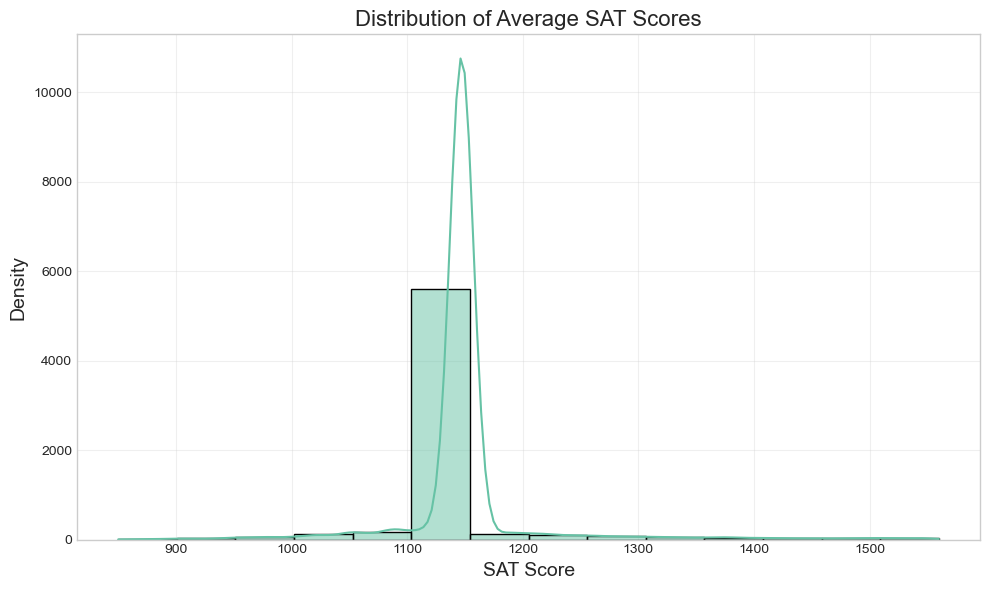

In [20]:
# Visualize SAT score distribution
plot_distribution(data, 'SAT_AVG', 'Distribution of Average SAT Scores', 'SAT Score')

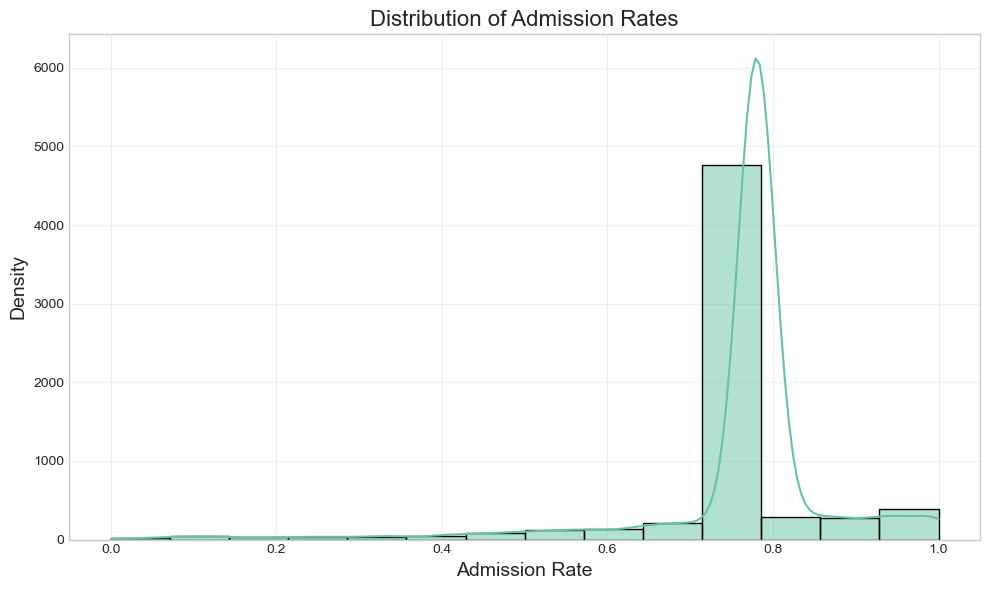

In [21]:
# Visualize admission rate distribution
plot_distribution(data, 'ADM_RATE', 'Distribution of Admission Rates', 'Admission Rate')

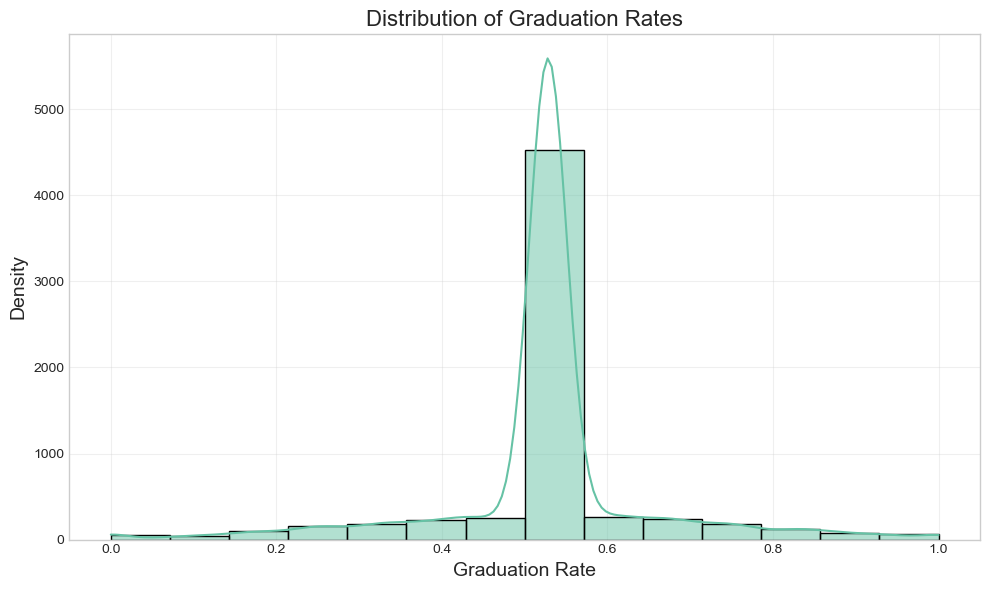

In [22]:
# Visualize graduation rate distribution
plot_distribution(data, 'C150_4', 'Distribution of Graduation Rates', 'Graduation Rate')

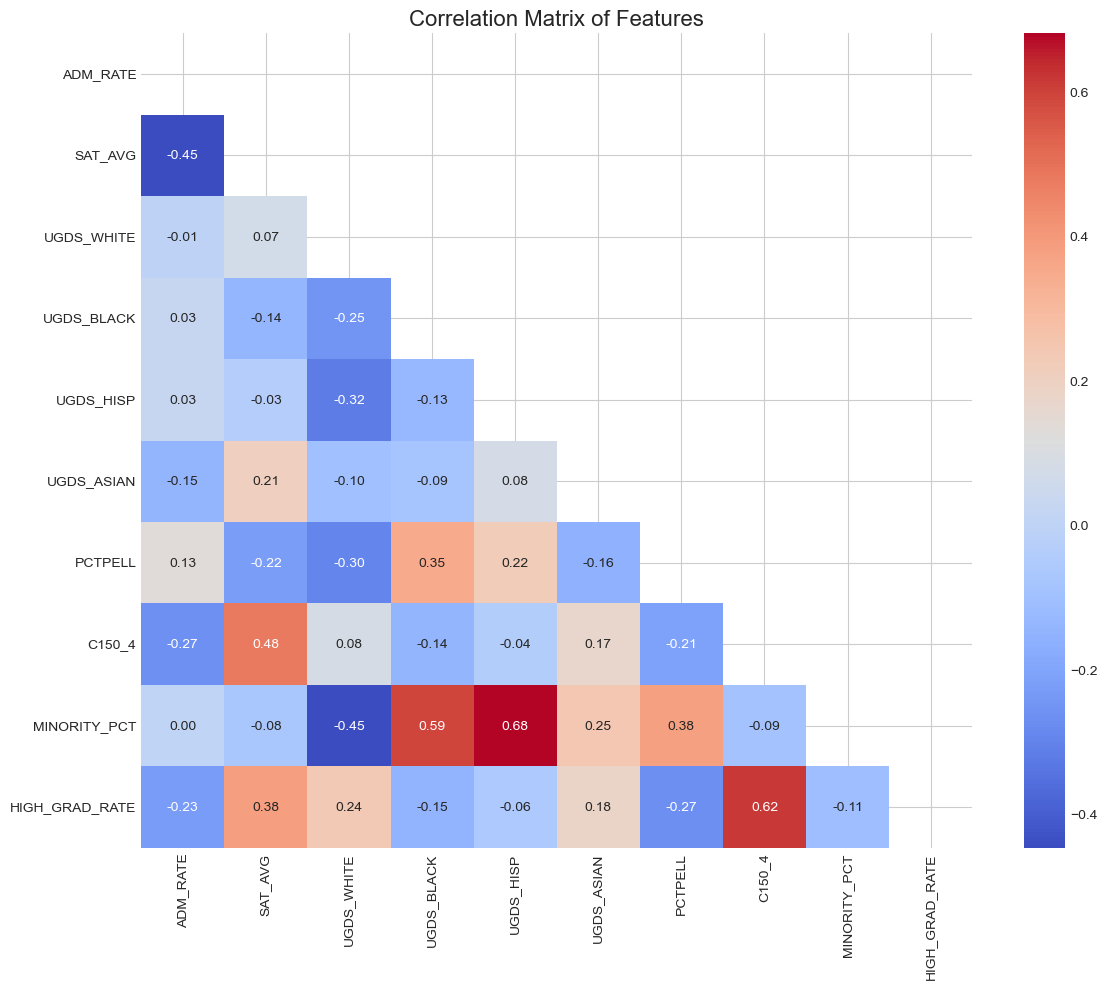

In [23]:
# Create a correlation matrix heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = data.drop(['INSTNM', 'ADMITTED'], axis=1).corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Correlation Matrix of Features", fontsize=16)
plt.tight_layout()
plt.show()

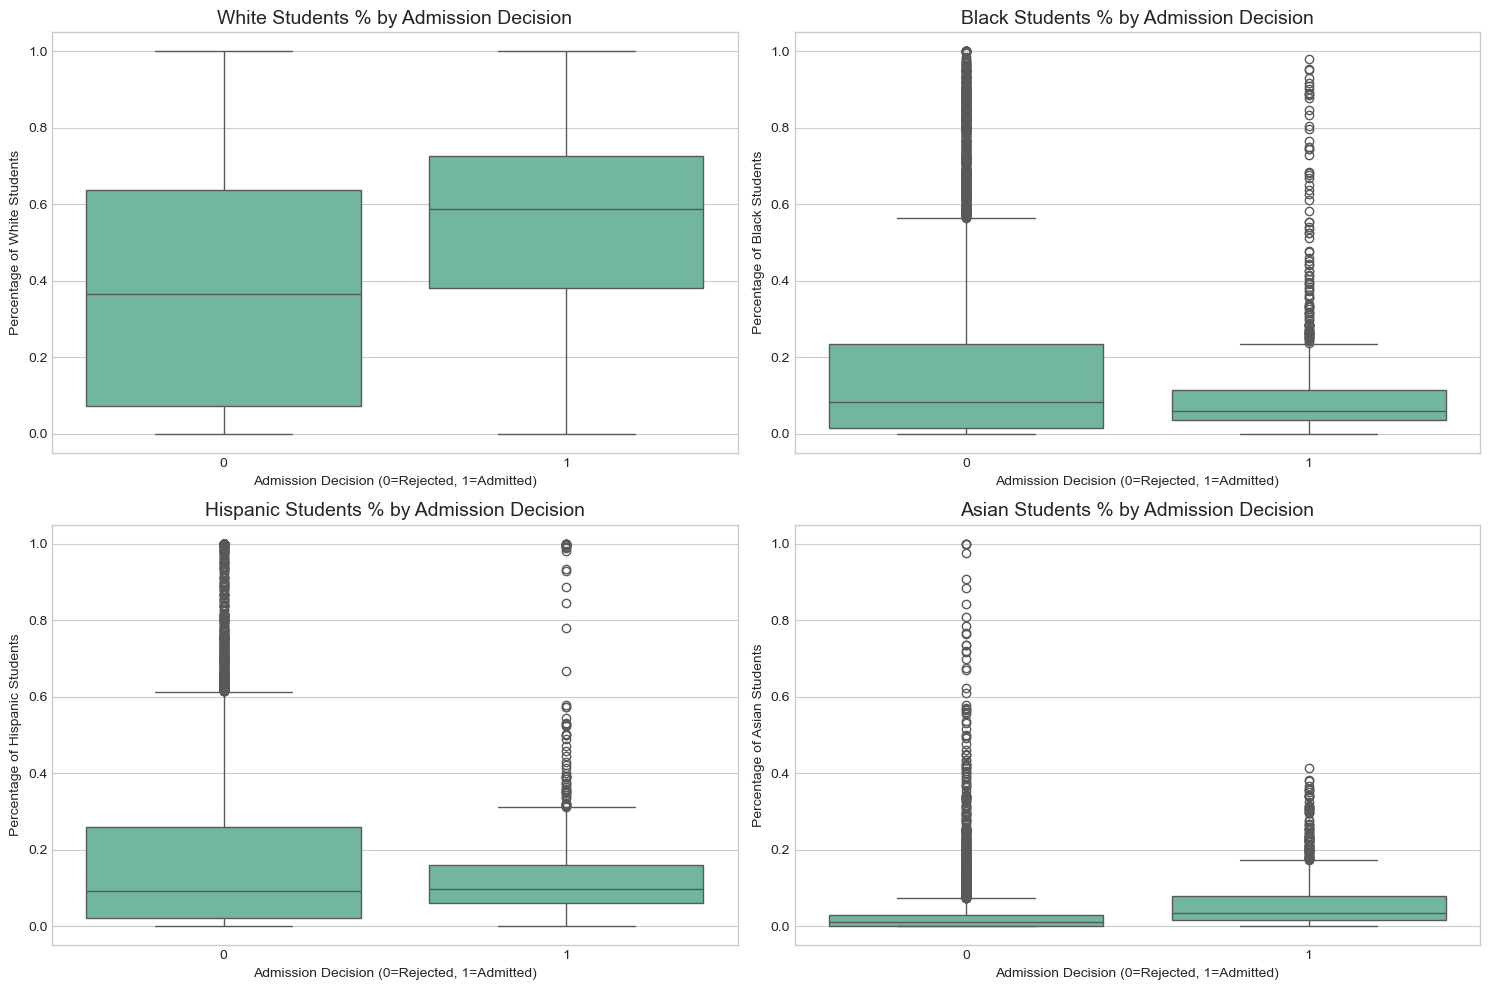

In [24]:
# Visualize the relationship between demographics and admission decisions
plt.figure(figsize=(15, 10))

# Create a 2x2 subplot
plt.subplot(2, 2, 1)
sns.boxplot(x='ADMITTED', y='UGDS_WHITE', data=data)
plt.title('White Students % by Admission Decision', fontsize=14)
plt.ylabel('Percentage of White Students')
plt.xlabel('Admission Decision (0=Rejected, 1=Admitted)')

plt.subplot(2, 2, 2)
sns.boxplot(x='ADMITTED', y='UGDS_BLACK', data=data)
plt.title('Black Students % by Admission Decision', fontsize=14)
plt.ylabel('Percentage of Black Students')
plt.xlabel('Admission Decision (0=Rejected, 1=Admitted)')

plt.subplot(2, 2, 3)
sns.boxplot(x='ADMITTED', y='UGDS_HISP', data=data)
plt.title('Hispanic Students % by Admission Decision', fontsize=14)
plt.ylabel('Percentage of Hispanic Students')
plt.xlabel('Admission Decision (0=Rejected, 1=Admitted)')

plt.subplot(2, 2, 4)
sns.boxplot(x='ADMITTED', y='UGDS_ASIAN', data=data)
plt.title('Asian Students % by Admission Decision', fontsize=14)
plt.ylabel('Percentage of Asian Students')
plt.xlabel('Admission Decision (0=Rejected, 1=Admitted)')

plt.tight_layout()
plt.show()

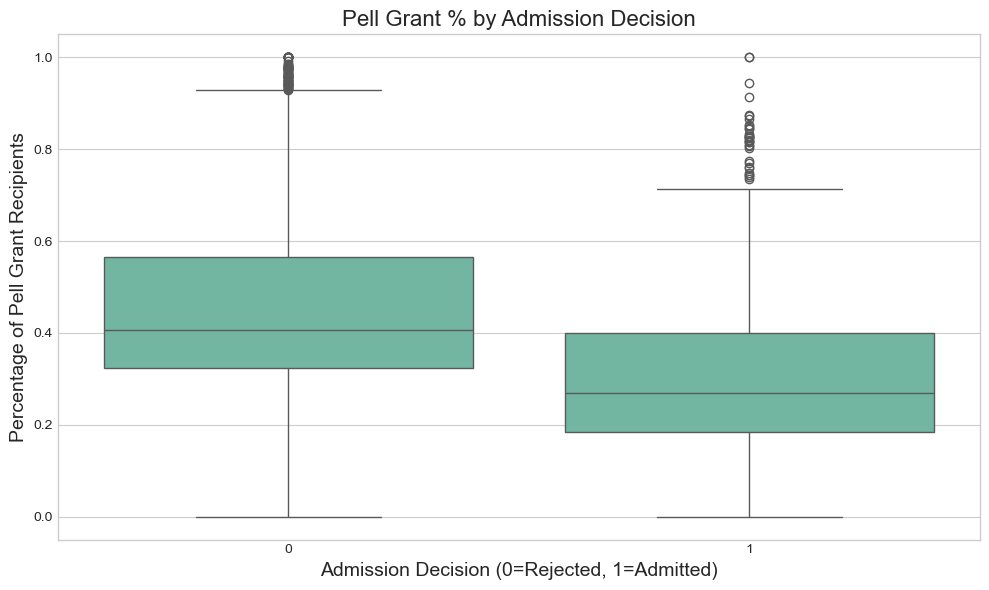

In [25]:
# Examine relationship between Pell Grant percentage and admission
plt.figure(figsize=(10, 6))
sns.boxplot(x='ADMITTED', y='PCTPELL', data=data)
plt.title('Pell Grant % by Admission Decision', fontsize=16)
plt.ylabel('Percentage of Pell Grant Recipients', fontsize=14)
plt.xlabel('Admission Decision (0=Rejected, 1=Admitted)', fontsize=14)
plt.tight_layout()
plt.show()

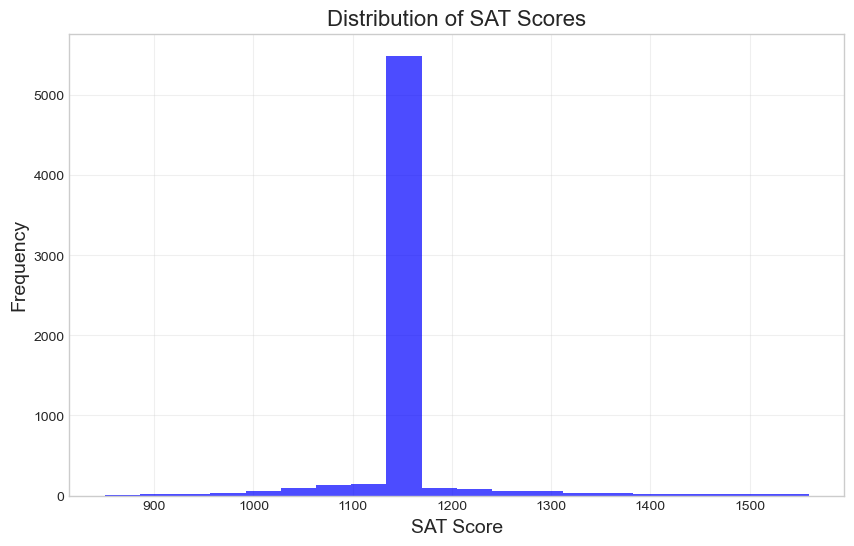

In [26]:
# Single histogram
plt.figure(figsize=(10, 6))
plt.hist(data['SAT_AVG'], bins=20, alpha=0.7, color='blue')
plt.title('Distribution of SAT Scores', fontsize=16)
plt.xlabel('SAT Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

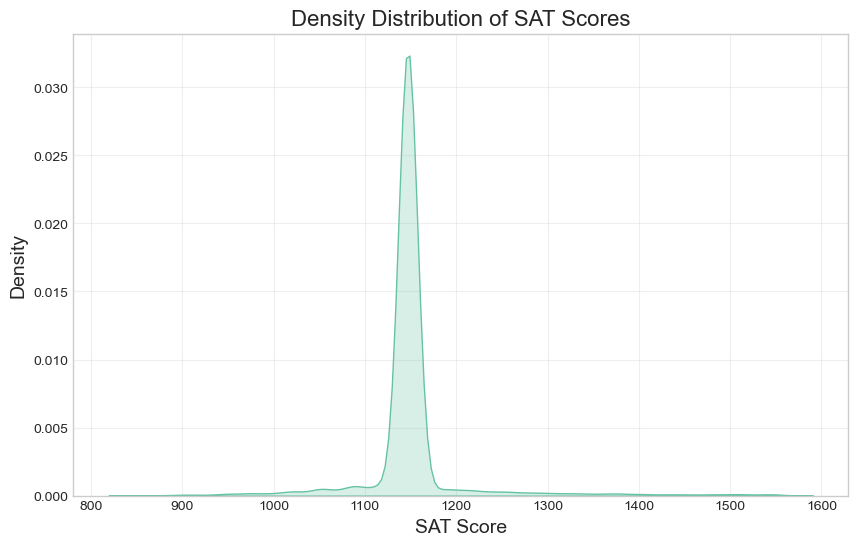

In [27]:
# Single KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(data['SAT_AVG'], fill=True)
plt.title('Density Distribution of SAT Scores', fontsize=16)
plt.xlabel('SAT Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

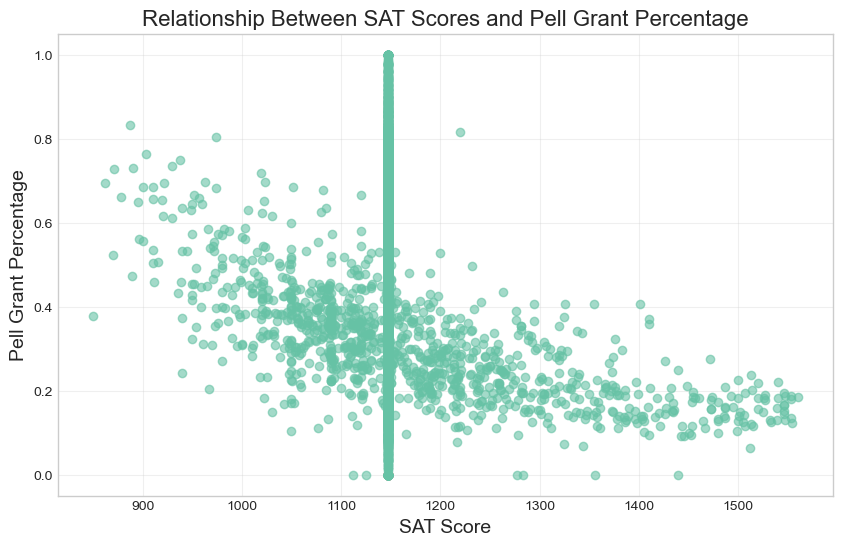

In [28]:
# Simple scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['SAT_AVG'], data['PCTPELL'], alpha=0.6)
plt.title('Relationship Between SAT Scores and Pell Grant Percentage', fontsize=16)
plt.xlabel('SAT Score', fontsize=14)
plt.ylabel('Pell Grant Percentage', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

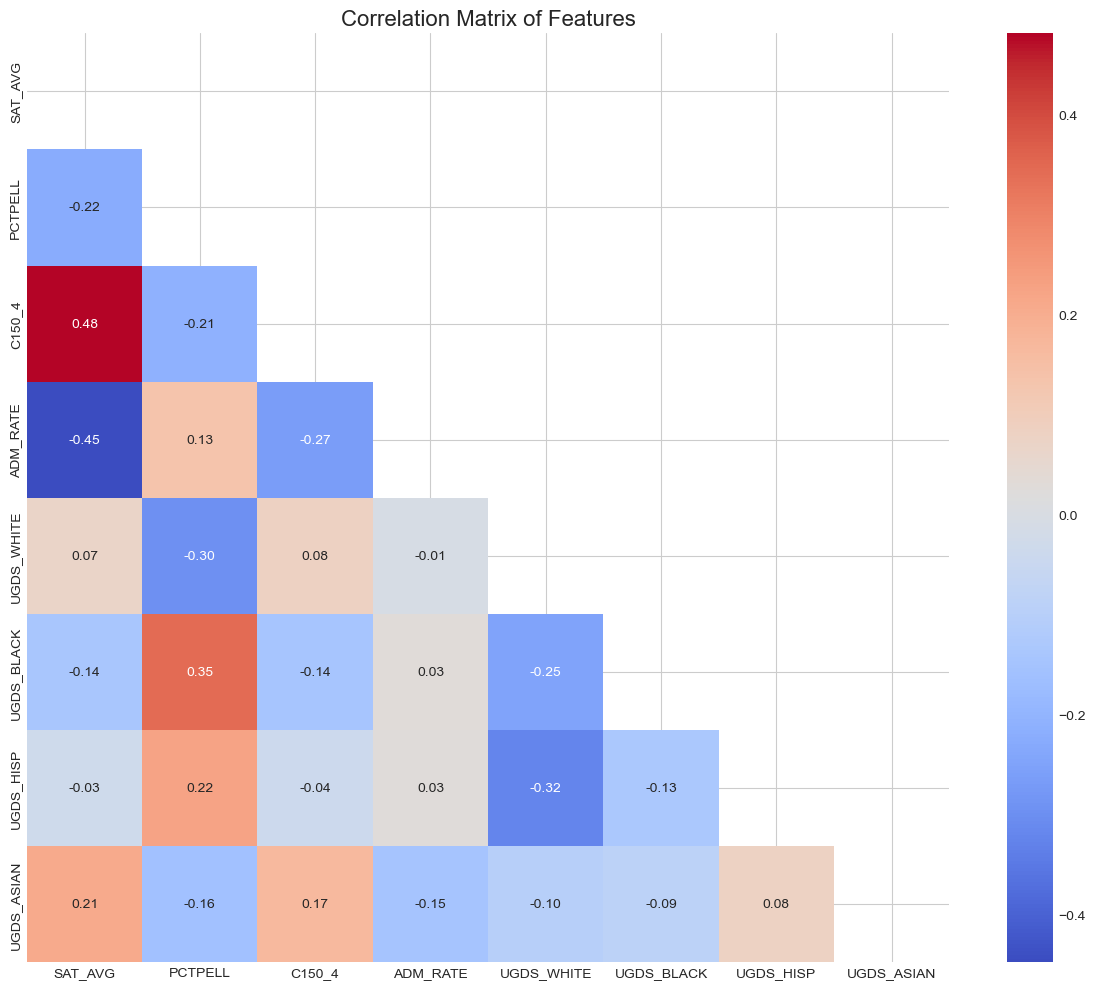

In [29]:
plt.figure(figsize=(12, 10))
correlation_matrix = data[['SAT_AVG', 'PCTPELL', 'C150_4', 'ADM_RATE', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN']].corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Correlation Matrix of Features", fontsize=16)
plt.tight_layout()
plt.show()

## Prepare Data for Modeling

In [30]:
# Prepare the dataset for machine learning
# Remove the institution name and create feature matrix
X = data.drop(['INSTNM', 'ADMITTED'], axis=1)
y = data['ADMITTED']

In [31]:
# Let's define the protected attribute - we'll consider the minority percentage as our protected attribute
# For the purpose of fairness analysis, we'll define a binary protected attribute
data['MINORITY_STATUS'] = (data['MINORITY_PCT'] > data['MINORITY_PCT'].median()).astype(int)
protected_attribute = data['MINORITY_STATUS']

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(X, y, protected_attribute, test_size=0.3, random_state=42)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Convert back to dataframes with column names for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (4538, 10)
Testing set shape: (1946, 10)


## Build Base Machine Learning Models

In [35]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate probabilities if the model supports it
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    # Create a results dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }
    
    return results, y_pred

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Evaluate all models
results_list = []
predictions = {}

for name, model in models.items():
    model_results, y_pred = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_list.append(model_results)
    predictions[name] = y_pred
    print(f"Evaluated: {name}")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_list)
print("\nModel Performance Comparison:")
results_df

Evaluated: Logistic Regression
Evaluated: Decision Tree
Evaluated: Random Forest
Evaluated: XGBoost

Model Performance Comparison:


Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression  0.989723   1.000000  0.923077  0.960000  0.999567
1        Decision Tree  0.996917   0.988462  0.988462  0.988462  0.993341
2        Random Forest  0.992806   0.965909  0.980769  0.973282  0.999648
3              XGBoost  0.995375   0.980843  0.984615  0.982726  0.999870

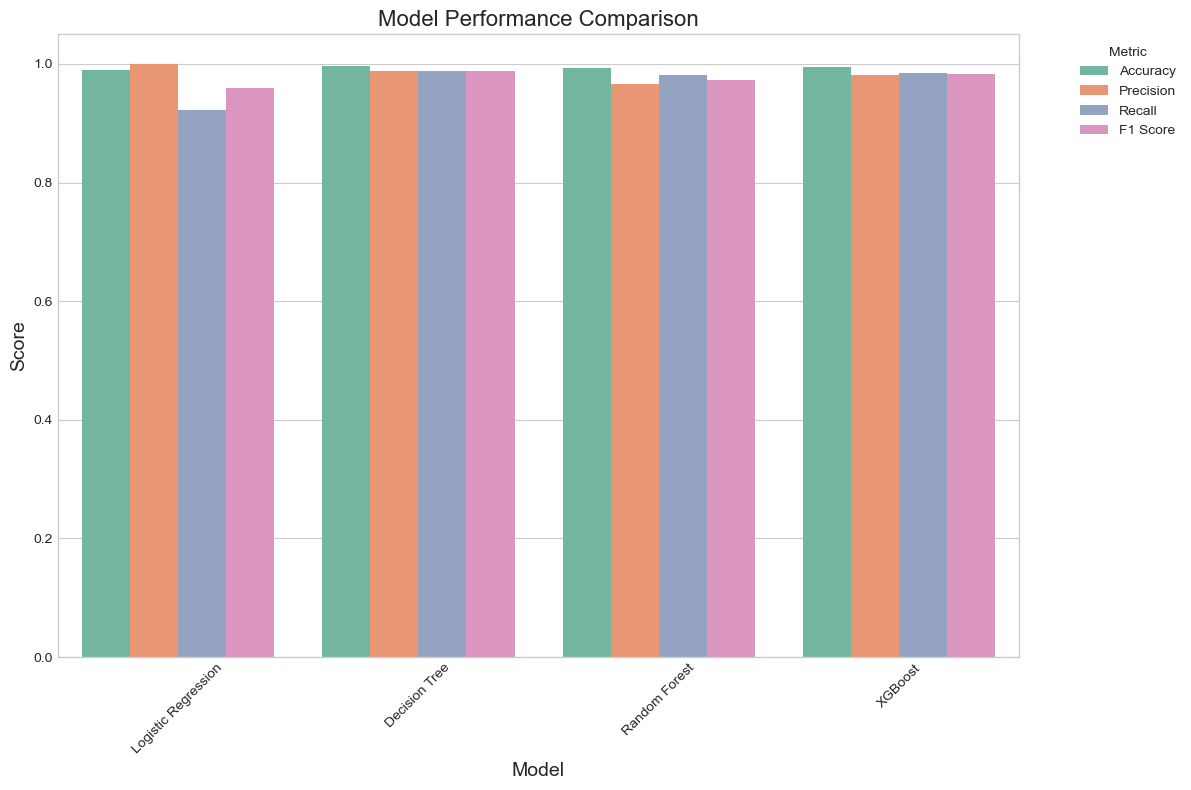

In [36]:
# Visualize model performance
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df_melt = pd.melt(results_df, id_vars=['Model'], value_vars=metrics, var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=results_df_melt)
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Implement Fairness Metrics and Evaluation

In [37]:
# Function to calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, protected_attribute):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    protected_attribute = np.array(protected_attribute)
    
    # Separate privileged and unprivileged groups
    # For our case, privilege=0 (majority), unprivileged=1 (minority)
    privileged_idx = (protected_attribute == 0)
    unprivileged_idx = (protected_attribute == 1)
    
    # Calculate acceptance rates for each group
    acceptance_rate_privileged = np.mean(y_pred[privileged_idx])
    acceptance_rate_unprivileged = np.mean(y_pred[unprivileged_idx])
    
    # Demographic Parity Difference (difference in acceptance rates)
    demographic_parity_difference = acceptance_rate_privileged - acceptance_rate_unprivileged
    
    # Disparate Impact Ratio (ratio of acceptance rates)
    # We want unprivileged / privileged, so that values < 1 indicate bias against unprivileged
    if acceptance_rate_privileged > 0:
        disparate_impact_ratio = acceptance_rate_unprivileged / acceptance_rate_privileged
    else:
        disparate_impact_ratio = np.nan
    
    # Equalized Odds - difference in true positive rates and false positive rates
    # True Positive Rate (TPR)
    tpr_privileged = np.sum((y_pred == 1) & (y_true == 1) & privileged_idx) / np.sum((y_true == 1) & privileged_idx) if np.sum((y_true == 1) & privileged_idx) > 0 else 0
    tpr_unprivileged = np.sum((y_pred == 1) & (y_true == 1) & unprivileged_idx) / np.sum((y_true == 1) & unprivileged_idx) if np.sum((y_true == 1) & unprivileged_idx) > 0 else 0
    
    # False Positive Rate (FPR)
    fpr_privileged = np.sum((y_pred == 1) & (y_true == 0) & privileged_idx) / np.sum((y_true == 0) & privileged_idx) if np.sum((y_true == 0) & privileged_idx) > 0 else 0
    fpr_unprivileged = np.sum((y_pred == 1) & (y_true == 0) & unprivileged_idx) / np.sum((y_true == 0) & unprivileged_idx) if np.sum((y_true == 0) & unprivileged_idx) > 0 else 0
    
    # Equalized Odds Difference
    tpr_difference = tpr_privileged - tpr_unprivileged
    fpr_difference = fpr_privileged - fpr_unprivileged
    equalized_odds_difference = (abs(tpr_difference) + abs(fpr_difference)) / 2
    
    # Return all metrics
    return {
        'Demographic Parity Difference': demographic_parity_difference,
        'Disparate Impact Ratio': disparate_impact_ratio,
        'TPR Difference': tpr_difference,
        'FPR Difference': fpr_difference,
        'Equalized Odds Difference': equalized_odds_difference,
        'Acceptance Rate (Majority)': acceptance_rate_privileged,
        'Acceptance Rate (Minority)': acceptance_rate_unprivileged
    }

# Calculate fairness metrics for all models
fairness_results = []

In [38]:
for name, y_pred in predictions.items():
    fairness_metrics = calculate_fairness_metrics(y_test, y_pred, protected_test)
    fairness_metrics['Model'] = name
    fairness_results.append(fairness_metrics)

# Convert to DataFrame
fairness_df = pd.DataFrame(fairness_results)
print("\nFairness Metrics Comparison:")
fairness_df


Fairness Metrics Comparison:


Demographic Parity Difference  Disparate Impact Ratio  TPR Difference  \
0                       0.064510                0.584928        0.010163   
1                       0.072627                0.572115        0.031250   
2                       0.070550                0.586839        0.035569   
3                       0.067483                0.597574       -0.007876   

   FPR Difference  Equalized Odds Difference  Acceptance Rate (Majority)  \
0        0.000000                   0.005081                    0.155419   
1        0.001310                   0.016280                    0.169734   
2       -0.000820                   0.018195                    0.170757   
3        0.001392                   0.004634                    0.167689   

   Acceptance Rate (Minority)                Model  
0                    0.090909  Logistic Regression  
1                    0.097107        Decision Tree  
2                    0.100207        Random Forest  
3                    0.100207              XGBoost

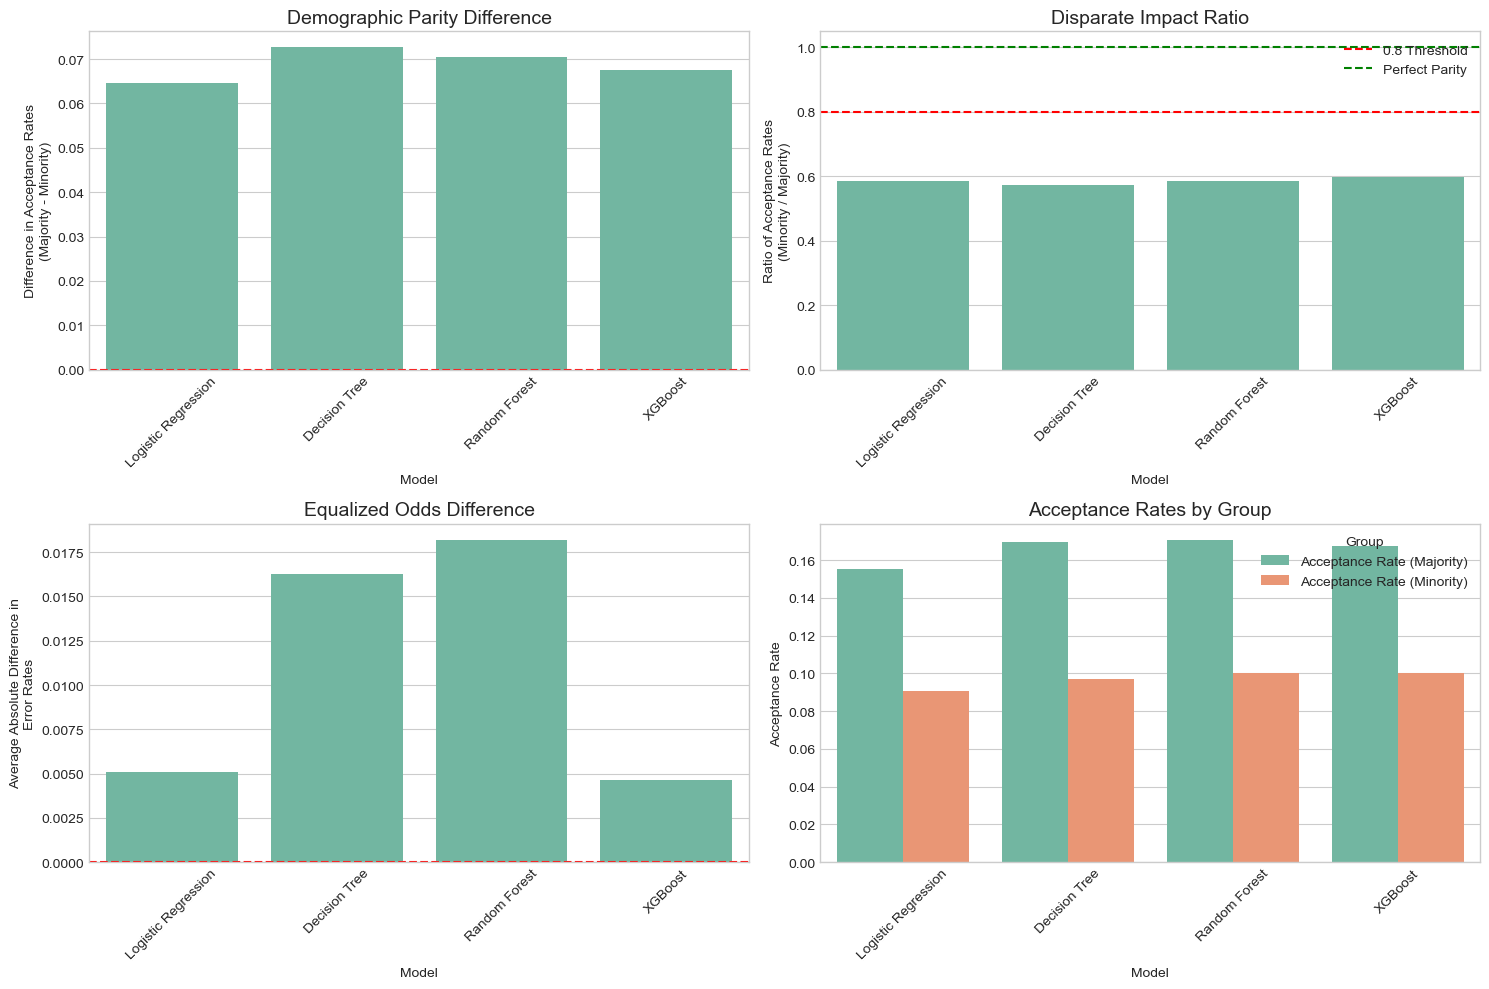

In [39]:
# Visualize fairness metrics
plt.figure(figsize=(15, 10))

# Plot Demographic Parity Difference
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Demographic Parity Difference', data=fairness_df)
plt.title('Demographic Parity Difference', fontsize=14)
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Difference in Acceptance Rates\n(Majority - Minority)')

# Plot Disparate Impact Ratio
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Disparate Impact Ratio', data=fairness_df)
plt.title('Disparate Impact Ratio', fontsize=14)
plt.axhline(y=0.8, color='r', linestyle='--', label='0.8 Threshold')
plt.axhline(y=1.0, color='g', linestyle='--', label='Perfect Parity')
plt.xticks(rotation=45)
plt.ylabel('Ratio of Acceptance Rates\n(Minority / Majority)')
plt.legend()

# Plot Equalized Odds Difference
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Equalized Odds Difference', data=fairness_df)
plt.title('Equalized Odds Difference', fontsize=14)
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Average Absolute Difference in\nError Rates')

# Plot Acceptance Rates
plt.subplot(2, 2, 4)
acceptance_rates = fairness_df[['Model', 'Acceptance Rate (Majority)', 'Acceptance Rate (Minority)']].melt(
    id_vars=['Model'], 
    var_name='Group', 
    value_name='Acceptance Rate'
)
sns.barplot(x='Model', y='Acceptance Rate', hue='Group', data=acceptance_rates)
plt.title('Acceptance Rates by Group', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Acceptance Rate')

plt.tight_layout()
plt.show()

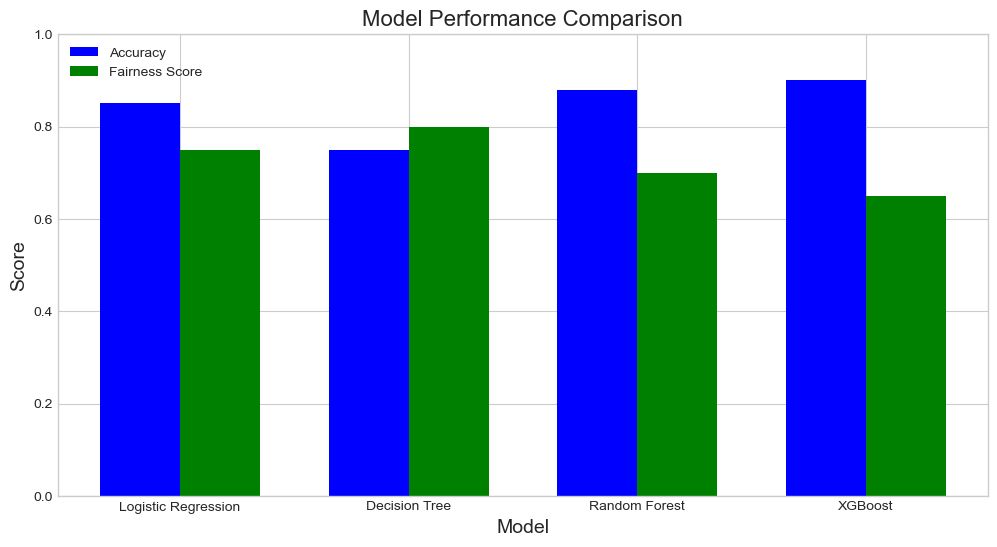

In [40]:
# Grouped bar chart
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy = [0.85, 0.75, 0.88, 0.90]
fairness = [0.75, 0.80, 0.70, 0.65]

bar_width = 0.35
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, accuracy, width=bar_width, label='Accuracy', color='blue')
plt.bar(r2, fairness, width=bar_width, label='Fairness Score', color='green')
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.legend()
plt.ylim(0, 1)
plt.show()

## Optimize Decision Tree Model with Hyperparameter Tuning

In [41]:
# Hyperparameter tuning for Decision Tree
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_leaf_nodes': [None, 10, 20, 30, 40]
}

# Initialize Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Setup grid search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Get the best model
best_dt = grid_search.best_estimator_

# Evaluate the optimized model
optimized_dt_results, optimized_dt_preds = evaluate_model(best_dt, X_train_scaled, X_test_scaled, y_train, y_test, "Optimized Decision Tree")
print("\nOptimized Decision Tree Performance:")
optimized_result = pd.DataFrame([optimized_dt_results])
optimized_result

Best parameters: {'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation score: 0.9965

Optimized Decision Tree Performance:


Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Optimized Decision Tree  0.997431   0.988506  0.992308  0.990403  0.995254

In [42]:
# Calculate fairness metrics for the optimized model
optimized_dt_fairness = calculate_fairness_metrics(y_test, optimized_dt_preds, protected_test)
optimized_dt_fairness['Model'] = "Optimized Decision Tree"
print("\nOptimized Decision Tree Fairness Metrics:")
optimizue_result = pd.DataFrame([optimized_dt_fairness])
optimizue_result


Optimized Decision Tree Fairness Metrics:


Demographic Parity Difference  Disparate Impact Ratio  TPR Difference  \
0                       0.071594                0.578201        0.020833   

   FPR Difference  Equalized Odds Difference  Acceptance Rate (Majority)  \
0         0.00131                   0.011072                    0.169734   

   Acceptance Rate (Minority)                    Model  
0                     0.09814  Optimized Decision Tree

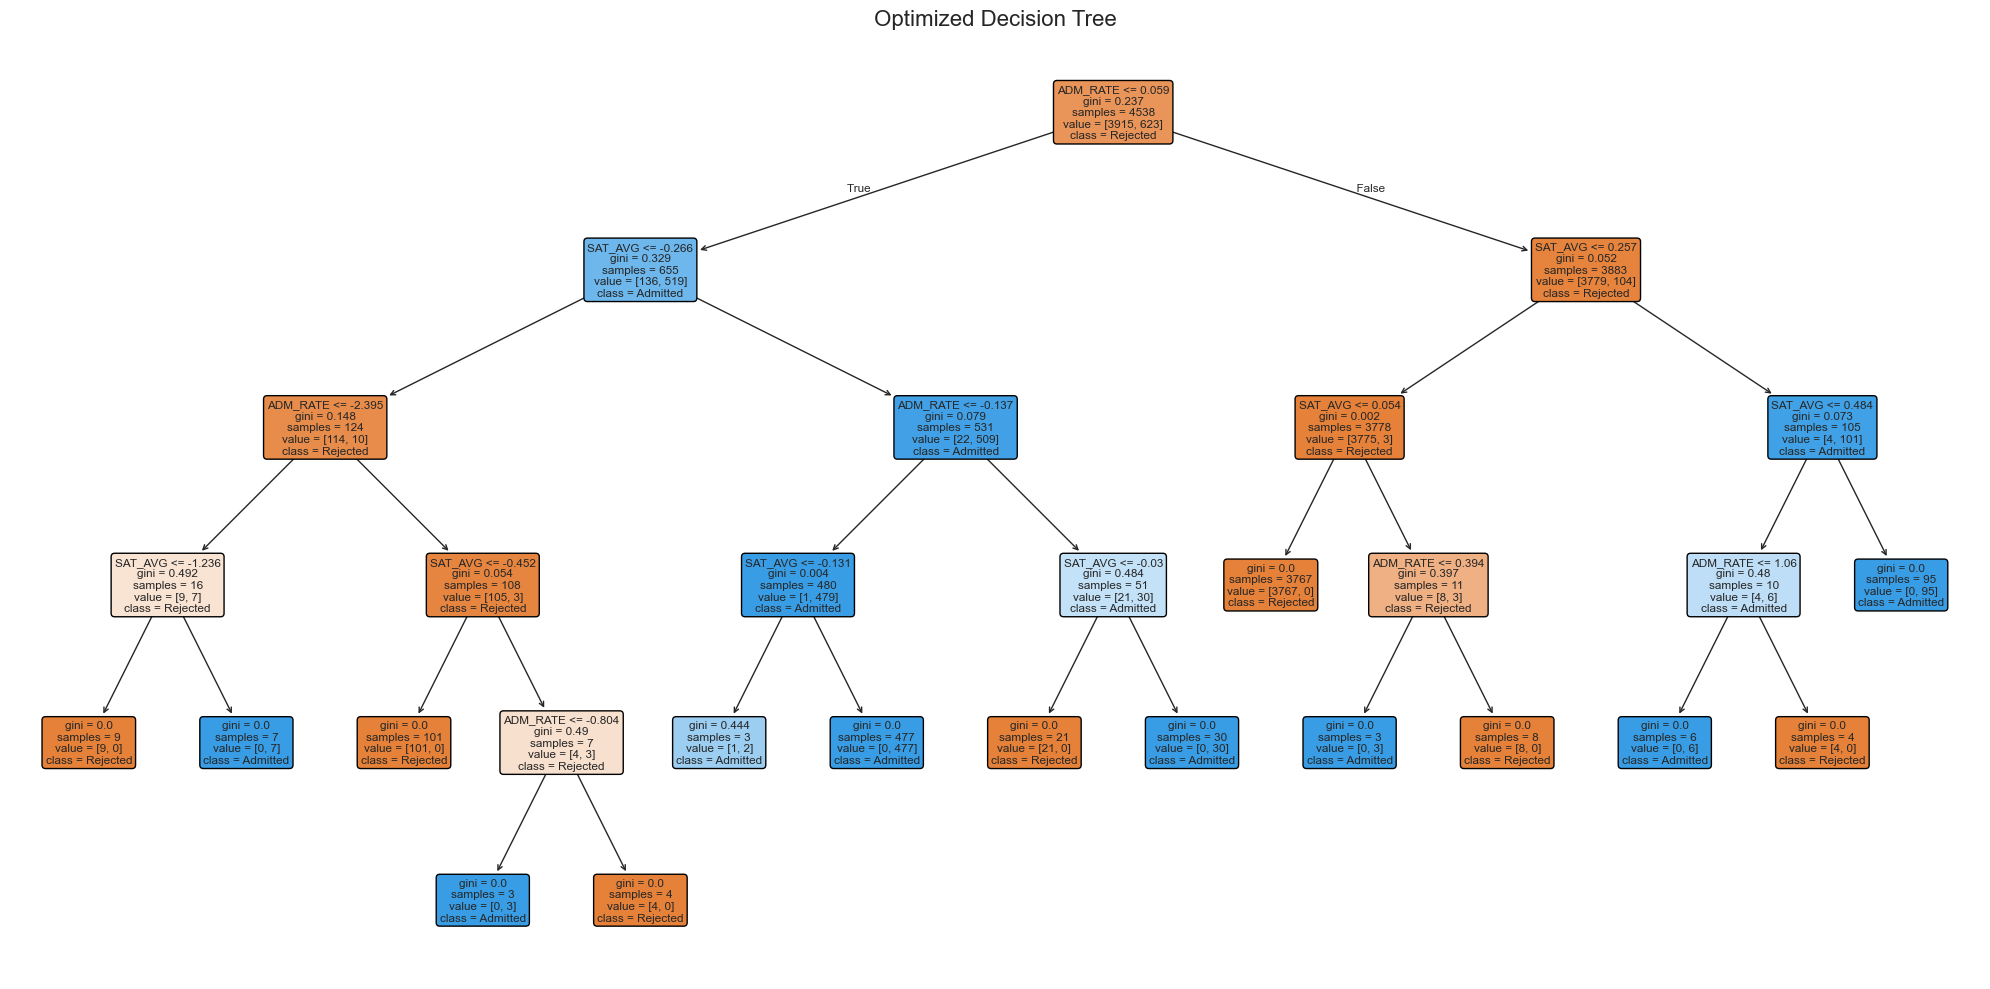

In [43]:
# Visualize the optimized decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(best_dt, feature_names=X_train.columns, class_names=['Rejected', 'Admitted'], filled=True, rounded=True)
plt.title("Optimized Decision Tree", fontsize=16)
plt.tight_layout()
plt.show()

## Implement Bias Mitigation Techniques

In [44]:
# Approach 1: Reweighting the training data
# Calculate weights to balance the dataset across protected attribute and outcome

def calculate_reweighting(y, protected_attribute):
    # Convert to numpy arrays
    y = np.array(y)
    protected_attribute = np.array(protected_attribute)
    
    # Calculate the frequency of each group
    n_samples = len(y)
    n_positives = np.sum(y == 1)
    n_negatives = n_samples - n_positives
    
    n_protected = np.sum(protected_attribute == 1)
    n_non_protected = n_samples - n_protected
    
    # Calculate joint frequencies
    n_protected_positives = np.sum((protected_attribute == 1) & (y == 1))
    n_protected_negatives = np.sum((protected_attribute == 1) & (y == 0))
    n_non_protected_positives = np.sum((protected_attribute == 0) & (y == 1))
    n_non_protected_negatives = np.sum((protected_attribute == 0) & (y == 0))
    
    # Calculate the weights
    weights = np.ones(n_samples)
    
    # Protected and positive
    weights[(protected_attribute == 1) & (y == 1)] = (n_samples / (2 * n_protected_positives)) if n_protected_positives > 0 else 1
    
    # Protected and negative
    weights[(protected_attribute == 1) & (y == 0)] = (n_samples / (2 * n_protected_negatives)) if n_protected_negatives > 0 else 1
    
    # Non-protected and positive
    weights[(protected_attribute == 0) & (y == 1)] = (n_samples / (2 * n_non_protected_positives)) if n_non_protected_positives > 0 else 1
    
    # Non-protected and negative
    weights[(protected_attribute == 0) & (y == 0)] = (n_samples / (2 * n_non_protected_negatives)) if n_non_protected_negatives > 0 else 1
    
    return weights

# Calculate the weights for the training data
sample_weights = calculate_reweighting(y_train, protected_train)

In [45]:
# Train models with reweighting
reweighted_models = {
    'Reweighted Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Reweighted Decision Tree': DecisionTreeClassifier(random_state=42),
    'Reweighted Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Reweighted XGBoost': xgb.XGBClassifier(random_state=42)
}

In [46]:
# Evaluate reweighted models
reweighted_results_list = []
reweighted_predictions = {}

In [47]:
for name, model in reweighted_models.items():
    # Fit the model with sample weights
    model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate probabilities if the model supports it
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    # Create a results dictionary
    results = {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }
    
    reweighted_results_list.append(results)
    reweighted_predictions[name] = y_pred
    print(f"Evaluated: {name}")


Evaluated: Reweighted Logistic Regression
Evaluated: Reweighted Decision Tree
Evaluated: Reweighted Random Forest
Evaluated: Reweighted XGBoost


In [48]:
# Convert results to DataFrame
reweighted_results_df = pd.DataFrame(reweighted_results_list)
print("\nReweighted Model Performance Comparison:")
reweighted_results_df


Reweighted Model Performance Comparison:


Model  Accuracy  Precision    Recall  F1 Score  \
0  Reweighted Logistic Regression  0.993320   0.969582  0.980769  0.975143   
1        Reweighted Decision Tree  0.994861   0.977099  0.984615  0.980843   
2        Reweighted Random Forest  0.993320   0.966038  0.984615  0.975238   
3              Reweighted XGBoost  0.995375   0.980843  0.984615  0.982726   

        AUC  
0  0.999891  
1  0.990528  
2  0.999633  
3  0.999799

In [49]:
# Calculate fairness metrics for reweighted models
reweighted_fairness_results = []

for name, y_pred in reweighted_predictions.items():
    fairness_metrics = calculate_fairness_metrics(y_test, y_pred, protected_test)
    fairness_metrics['Model'] = name
    reweighted_fairness_results.append(fairness_metrics)

# Convert to DataFrame
reweighted_fairness_df = pd.DataFrame(reweighted_fairness_results)
print("\nReweighted Models Fairness Metrics:")
reweighted_fairness_df


Reweighted Models Fairness Metrics:


Demographic Parity Difference  Disparate Impact Ratio  TPR Difference  \
0                       0.065416                0.609895        0.002541   
1                       0.068505                0.593952        0.008638   
2                       0.071573                0.583346        0.041667   
3                       0.069538                0.587829        0.008638   

   FPR Difference  Equalized Odds Difference  Acceptance Rate (Majority)  \
0       -0.002048                   0.002295                    0.167689   
1        0.000245                   0.004442                    0.168712   
2       -0.000820                   0.021243                    0.171779   
3        0.001392                   0.005015                    0.168712   

   Acceptance Rate (Minority)                           Model  
0                    0.102273  Reweighted Logistic Regression  
1                    0.100207        Reweighted Decision Tree  
2                    0.100207        Reweighted Random Forest  
3                    0.099174              Reweighted XGBoost

In [50]:
# Approach 2: Threshold Optimization for Equalized Odds
# This is a post-processing technique where we find optimal thresholds for different groups

def threshold_optimization(y_true, y_scores, protected_attribute):
    """Find optimal thresholds for different groups to equalize odds"""
    # Separate privileged and unprivileged groups
    privileged_idx = (protected_attribute == 0)
    unprivileged_idx = (protected_attribute == 1)
    
    y_true_privileged = y_true[privileged_idx]
    y_scores_privileged = y_scores[privileged_idx]
    
    y_true_unprivileged = y_true[unprivileged_idx]
    y_scores_unprivileged = y_scores[unprivileged_idx]
    
    # Try different thresholds
    thresholds = np.linspace(0, 1, 100)
    
    # Store metrics for each threshold
    tpr_diffs = []
    fpr_diffs = []
    overall_accuracy = []
    
    # Store the best thresholds
    best_threshold_privileged = 0.5
    best_threshold_unprivileged = 0.5
    min_eq_odds_diff = float('inf')
    
    for t_privileged in thresholds:
        for t_unprivileged in thresholds:
            # Make predictions using the thresholds
            y_pred_privileged = (y_scores_privileged >= t_privileged).astype(int)
            y_pred_unprivileged = (y_scores_unprivileged >= t_unprivileged).astype(int)
            
            # Calculate TPR for both groups
            tpr_privileged = np.sum((y_pred_privileged == 1) & (y_true_privileged == 1)) / np.sum(y_true_privileged == 1) if np.sum(y_true_privileged == 1) > 0 else 0
            tpr_unprivileged = np.sum((y_pred_unprivileged == 1) & (y_true_unprivileged == 1)) / np.sum(y_true_unprivileged == 1) if np.sum(y_true_unprivileged == 1) > 0 else 0
            
            # Calculate FPR for both groups
            fpr_privileged = np.sum((y_pred_privileged == 1) & (y_true_privileged == 0)) / np.sum(y_true_privileged == 0) if np.sum(y_true_privileged == 0) > 0 else 0
            fpr_unprivileged = np.sum((y_pred_unprivileged == 1) & (y_true_unprivileged == 0)) / np.sum(y_true_unprivileged == 0) if np.sum(y_true_unprivileged == 0) > 0 else 0
            
            # Calculate differences
            tpr_diff = abs(tpr_privileged - tpr_unprivileged)
            fpr_diff = abs(fpr_privileged - fpr_unprivileged)
            
            # Equalized odds difference
            eq_odds_diff = (tpr_diff + fpr_diff) / 2
            
            # Calculate overall accuracy
            y_pred_combined = np.zeros_like(y_true)
            y_pred_combined[privileged_idx] = y_pred_privileged
            y_pred_combined[unprivileged_idx] = y_pred_unprivileged
            acc = accuracy_score(y_true, y_pred_combined)
            
            # Check if this is the best equalized odds so far
            if eq_odds_diff < min_eq_odds_diff:
                min_eq_odds_diff = eq_odds_diff
                best_threshold_privileged = t_privileged
                best_threshold_unprivileged = t_unprivileged
    
    return best_threshold_privileged, best_threshold_unprivileged

In [51]:
# Apply threshold optimization to the XGBoost model
# First, get the probability scores

xgb_model = reweighted_models['Reweighted XGBoost'] 
y_scores = xgb_model.predict_proba(X_test_scaled)[:, 1]

In [52]:
# Find optimal thresholds
threshold_privileged, threshold_unprivileged = threshold_optimization(y_test.values, y_scores, protected_test.values)
print(f"\nOptimal Thresholds - Privileged: {threshold_privileged:.3f}, Unprivileged: {threshold_unprivileged:.3f}")


Optimal Thresholds - Privileged: 0.000, Unprivileged: 0.000


In [53]:
# Apply the thresholds to make predictions
y_pred_threshold_optimized = np.zeros_like(y_test.values)
privileged_idx = (protected_test.values == 0)
unprivileged_idx = (protected_test.values == 1)

y_pred_threshold_optimized[privileged_idx] = (y_scores[privileged_idx] >= threshold_privileged).astype(int)
y_pred_threshold_optimized[unprivileged_idx] = (y_scores[unprivileged_idx] >= threshold_unprivileged).astype(int)

In [54]:
# Evaluate performance of threshold-optimized model
threshold_optimized_accuracy = accuracy_score(y_test, y_pred_threshold_optimized)
threshold_optimized_precision = precision_score(y_test, y_pred_threshold_optimized)
threshold_optimized_recall = recall_score(y_test, y_pred_threshold_optimized)
threshold_optimized_f1 = f1_score(y_test, y_pred_threshold_optimized)

In [55]:
threshold_optimized_results = {
    'Model': 'Threshold-Optimized XGBoost',
    'Accuracy': threshold_optimized_accuracy,
    'Precision': threshold_optimized_precision,
    'Recall': threshold_optimized_recall,
    'F1 Score': threshold_optimized_f1,
    'AUC': roc_auc_score(y_test, y_scores)  # Using original scores for AUC
}

print("\nThreshold-Optimized XGBoost Performance:")
thres_opti = pd.DataFrame([threshold_optimized_results])
thres_opti


Threshold-Optimized XGBoost Performance:


Model  Accuracy  Precision  Recall  F1 Score  \
0  Threshold-Optimized XGBoost  0.133607   0.133607     1.0  0.235721   

        AUC  
0  0.999799

In [56]:
# Calculate fairness metrics for threshold-optimized model
threshold_optimized_fairness = calculate_fairness_metrics(y_test, y_pred_threshold_optimized, protected_test)
threshold_optimized_fairness['Model'] = "Threshold-Optimized XGBoost"
print("\nThreshold-Optimized XGBoost Fairness Metrics:")
thre_optimized_fairness = pd.DataFrame([threshold_optimized_fairness])
thre_optimized_fairness


Threshold-Optimized XGBoost Fairness Metrics:


Demographic Parity Difference  Disparate Impact Ratio  TPR Difference  \
0                            0.0                     1.0             0.0   

   FPR Difference  Equalized Odds Difference  Acceptance Rate (Majority)  \
0             0.0                        0.0                         1.0   

   Acceptance Rate (Minority)                        Model  
0                         1.0  Threshold-Optimized XGBoost

In [57]:
# Approach 3: Use a fairness constraint during model training 
# For demonstration, we'll use a simple approach with logistic regression
# by removing certain features that might introduce bias

# Train a model without demographic features
X_train_no_demo = X_train_scaled.drop(['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'MINORITY_PCT'], axis=1)
X_test_no_demo = X_test_scaled.drop(['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'MINORITY_PCT'], axis=1)

In [58]:
# Train the model
fair_model = LogisticRegression(max_iter=1000, random_state=42)
fair_model.fit(X_train_no_demo, y_train)

# Make predictions
fair_model_pred = fair_model.predict(X_test_no_demo)

In [59]:
# Evaluate performance
fair_model_results = {
    'Model': 'Fairness-Constrained LR',
    'Accuracy': accuracy_score(y_test, fair_model_pred),
    'Precision': precision_score(y_test, fair_model_pred),
    'Recall': recall_score(y_test, fair_model_pred),
    'F1 Score': f1_score(y_test, fair_model_pred),
    'AUC': roc_auc_score(y_test, fair_model.predict_proba(X_test_no_demo)[:, 1])
}

In [60]:
print("\nFairness-Constrained Logistic Regression Performance:")
fair_model_res = pd.DataFrame([fair_model_results])
fair_model_res


Fairness-Constrained Logistic Regression Performance:


Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Fairness-Constrained LR   0.99075        1.0  0.930769  0.964143  0.999626

In [61]:
# Calculate fairness metrics for the fair model
fair_model_fairness = calculate_fairness_metrics(y_test, fair_model_pred, protected_test)
fair_model_fairness['Model'] = "Fairness-Constrained LR"
print("\nFairness-Constrained Logistic Regression Fairness Metrics:")
fair_model_fairn = pd.DataFrame([fair_model_fairness])
fair_model_fairn


Fairness-Constrained Logistic Regression Fairness Metrics:


Demographic Parity Difference  Disparate Impact Ratio  TPR Difference  \
0                       0.062444                0.598222       -0.010671   

   FPR Difference  Equalized Odds Difference  Acceptance Rate (Majority)  \
0             0.0                   0.005335                    0.155419   

   Acceptance Rate (Minority)                    Model  
0                    0.092975  Fairness-Constrained LR

In [62]:
# Combine all model results
all_model_results = pd.concat([
    results_df,
    pd.DataFrame([optimized_dt_results]),
    reweighted_results_df,
    pd.DataFrame([threshold_optimized_results]),
    pd.DataFrame([fair_model_results])
])

In [63]:
# Combine all fairness results
all_model_fairness = pd.concat([
    fairness_df,
    pd.DataFrame([optimized_dt_fairness]),
    reweighted_fairness_df,
    pd.DataFrame([threshold_optimized_fairness]),
    pd.DataFrame([fair_model_fairness])
])

In [64]:
# Create a unified dataframe for visualization
model_comparison = all_model_results[['Model', 'Accuracy', 'F1 Score']].merge(
    all_model_fairness[['Model', 'Demographic Parity Difference', 'Disparate Impact Ratio', 'Equalized Odds Difference']],
    on='Model'
)

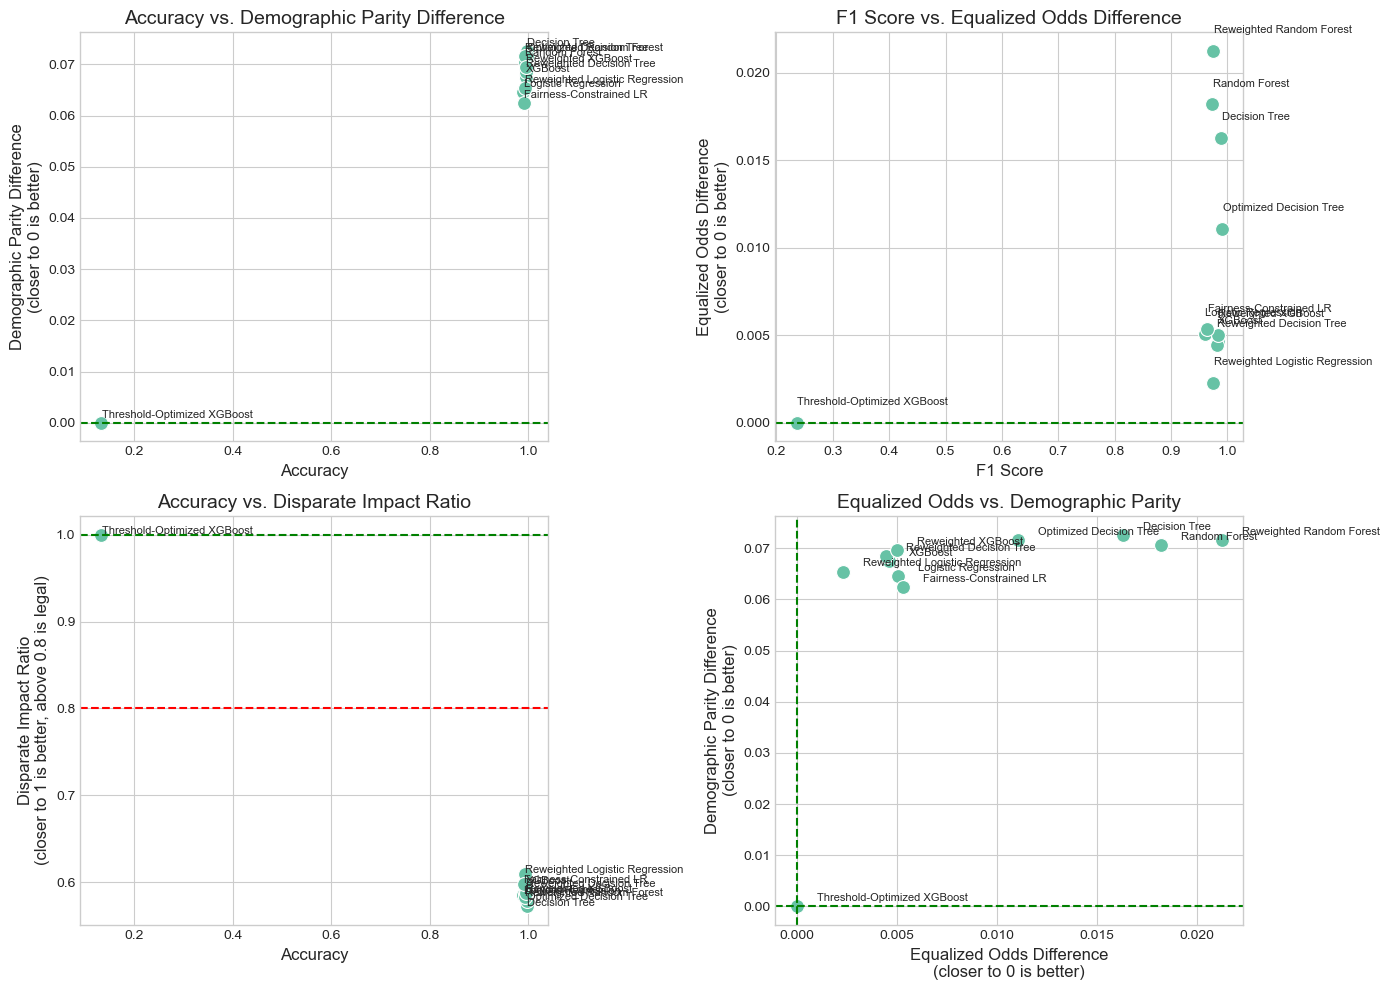

In [65]:
# Create visualization of the trade-off between performance and fairness
plt.figure(figsize=(14, 10))

# Plot accuracy vs. demographic parity
plt.subplot(2, 2, 1)
sns.scatterplot(x='Accuracy', y='Demographic Parity Difference', data=model_comparison, s=100)
for i, row in model_comparison.iterrows():
    plt.text(row['Accuracy']+0.001, row['Demographic Parity Difference']+0.001, row['Model'], fontsize=8)
plt.axhline(y=0, color='g', linestyle='--')
plt.title('Accuracy vs. Demographic Parity Difference', fontsize=14)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Demographic Parity Difference\n(closer to 0 is better)', fontsize=12)

# Plot F1 Score vs. equalized odds
plt.subplot(2, 2, 2)
sns.scatterplot(x='F1 Score', y='Equalized Odds Difference', data=model_comparison, s=100)
for i, row in model_comparison.iterrows():
    plt.text(row['F1 Score']+0.001, row['Equalized Odds Difference']+0.001, row['Model'], fontsize=8)
plt.axhline(y=0, color='g', linestyle='--')
plt.title('F1 Score vs. Equalized Odds Difference', fontsize=14)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Equalized Odds Difference\n(closer to 0 is better)', fontsize=12)

# Plot accuracy vs. disparate impact ratio
plt.subplot(2, 2, 3)
sns.scatterplot(x='Accuracy', y='Disparate Impact Ratio', data=model_comparison, s=100)
for i, row in model_comparison.iterrows():
    plt.text(row['Accuracy']+0.001, row['Disparate Impact Ratio']+0.001, row['Model'], fontsize=8)
plt.axhline(y=1.0, color='g', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.title('Accuracy vs. Disparate Impact Ratio', fontsize=14)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Disparate Impact Ratio\n(closer to 1 is better, above 0.8 is legal)', fontsize=12)

# Plot equalized odds vs. demographic parity
plt.subplot(2, 2, 4)
sns.scatterplot(x='Equalized Odds Difference', y='Demographic Parity Difference', data=model_comparison, s=100)
for i, row in model_comparison.iterrows():
    plt.text(row['Equalized Odds Difference']+0.001, row['Demographic Parity Difference']+0.001, row['Model'], fontsize=8)
plt.axhline(y=0, color='g', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
plt.title('Equalized Odds vs. Demographic Parity', fontsize=14)
plt.xlabel('Equalized Odds Difference\n(closer to 0 is better)', fontsize=12)
plt.ylabel('Demographic Parity Difference\n(closer to 0 is better)', fontsize=12)

plt.tight_layout()
plt.show()

In [66]:
# Function to create a fairness dashboard
def create_fairness_dashboard(model_comparison):
    # Create a figure with subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Accuracy vs. Demographic Parity Difference',
            'F1 Score vs. Equalized Odds Difference',
            'Accuracy vs. Disparate Impact Ratio',
            'Performance-Fairness Tradeoff'
        ),
        specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
               [{'type': 'scatter'}, {'type': 'bar'}]]
    )
    
    # Add traces for accuracy vs. demographic parity
    fig.add_trace(
        go.Scatter(
            x=model_comparison['Accuracy'],
            y=model_comparison['Demographic Parity Difference'],
            mode='markers+text',
            marker=dict(size=12, color='blue'),
            text=model_comparison['Model'],
            textposition="top center",
            name='Demographic Parity'
        ),
        row=1, col=1
    )
    
    # Add reference line at y=0
    fig.add_shape(
        type='line',
        x0=min(model_comparison['Accuracy']) - 0.05,
        y0=0,
        x1=max(model_comparison['Accuracy']) + 0.05,
        y1=0,
        line=dict(color='green', dash='dash'),
        row=1, col=1
    )
    
    # Add traces for F1 Score vs. equalized odds
    fig.add_trace(
        go.Scatter(
            x=model_comparison['F1 Score'],
            y=model_comparison['Equalized Odds Difference'],
            mode='markers+text',
            marker=dict(size=12, color='red'),
            text=model_comparison['Model'],
            textposition="top center",
            name='Equalized Odds'
        ),
        row=1, col=2
    )
    
    # Add reference line at y=0
    fig.add_shape(
        type='line',
        x0=min(model_comparison['F1 Score']) - 0.05,
        y0=0,
        x1=max(model_comparison['F1 Score']) + 0.05,
        y1=0,
        line=dict(color='green', dash='dash'),
        row=1, col=2
    )
    
    # Add traces for accuracy vs. disparate impact ratio
    fig.add_trace(
        go.Scatter(
            x=model_comparison['Accuracy'],
            y=model_comparison['Disparate Impact Ratio'],
            mode='markers+text',
            marker=dict(size=12, color='purple'),
            text=model_comparison['Model'],
            textposition="top center",
            name='Disparate Impact'
        ),
        row=2, col=1
    )
    
    # Add reference lines at y=1.0 and y=0.8
    fig.add_shape(
        type='line',
        x0=min(model_comparison['Accuracy']) - 0.05,
        y0=1.0,
        x1=max(model_comparison['Accuracy']) + 0.05,
        y1=1.0,
        line=dict(color='green', dash='dash'),
        row=2, col=1
    )
    
    fig.add_shape(
        type='line',
        x0=min(model_comparison['Accuracy']) - 0.05,
        y0=0.8,
        x1=max(model_comparison['Accuracy']) + 0.05,
        y1=0.8,
        line=dict(color='red', dash='dash'),
        row=2, col=1
    )
    
    # Add a bar chart comparing performance and fairness for each model
    # Calculate a fairness score (inverse of the sum of absolute fairness metrics)
    model_comparison['Fairness Score'] = 1 / (
        abs(model_comparison['Demographic Parity Difference']) + 
        abs(1 - model_comparison['Disparate Impact Ratio']) + 
        abs(model_comparison['Equalized Odds Difference']) + 
        0.01  # To avoid division by zero
    )
    
    # Normalize the fairness score
    max_fairness = model_comparison['Fairness Score'].max()
    model_comparison['Fairness Score'] = model_comparison['Fairness Score'] / max_fairness
    
    # Create a bar chart
    fig.add_trace(
        go.Bar(
            x=model_comparison['Model'],
            y=model_comparison['Accuracy'],
            name='Accuracy',
            marker_color='blue'
        ),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Bar(
            x=model_comparison['Model'],
            y=model_comparison['Fairness Score'],
            name='Fairness Score',
            marker_color='green'
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="Fairness Dashboard for College Admissions AI",
        height=800,
        width=1200,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    # Update axis labels
    fig.update_xaxes(title_text="Accuracy", row=1, col=1)
    fig.update_yaxes(title_text="Demographic Parity Difference (closer to 0 is better)", row=1, col=1)
    
    fig.update_xaxes(title_text="F1 Score", row=1, col=2)
    fig.update_yaxes(title_text="Equalized Odds Difference (closer to 0 is better)", row=1, col=2)
    
    fig.update_xaxes(title_text="Accuracy", row=2, col=1)
    fig.update_yaxes(title_text="Disparate Impact Ratio (closer to 1 is better, above 0.8 is legal)", row=2, col=1)
    
    fig.update_xaxes(title_text="Model", row=2, col=2)
    fig.update_yaxes(title_text="Score (0-1 scale)", row=2, col=2)
    
    return fig


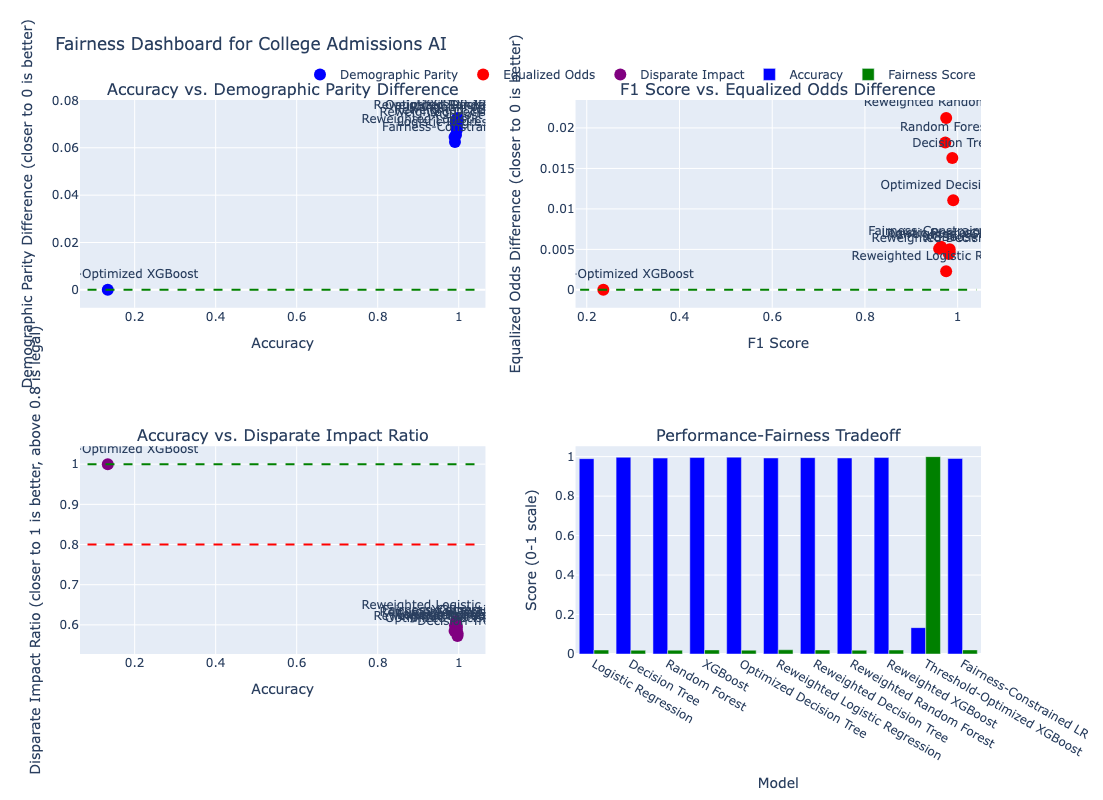

Fairness dashboard has been saved to 'fairness_dashboard.html'


In [67]:
# Create and display the dashboard
dashboard = create_fairness_dashboard(model_comparison)
dashboard.show()

# Save the dashboard to an HTML file for sharing
dashboard.write_html("fairness_dashboard.html")
print("Fairness dashboard has been saved to 'fairness_dashboard.html'")

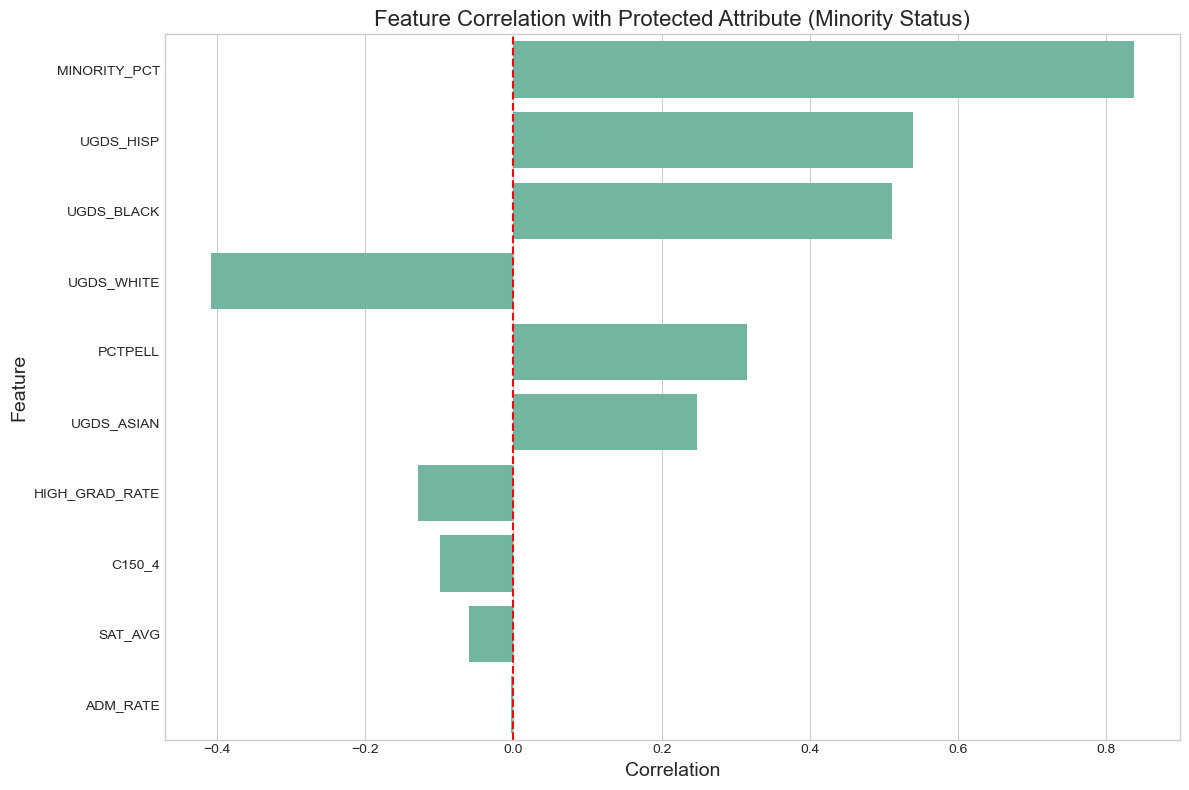

In [68]:
# Analyze the impact of each feature on fairness
# We'll use correlation between features and protected attribute
feature_protected_corr = []

for feature in X_train.columns:
    correlation = np.corrcoef(X_train[feature], protected_train)[0, 1]
    feature_protected_corr.append({
        'Feature': feature,
        'Correlation with Protected Attribute': correlation
    })

feature_protected_corr_df = pd.DataFrame(feature_protected_corr).sort_values('Correlation with Protected Attribute', key=abs, ascending=False)

# Visualize correlation with protected attribute
plt.figure(figsize=(12, 8))
sns.barplot(x='Correlation with Protected Attribute', y='Feature', data=feature_protected_corr_df)
plt.title('Feature Correlation with Protected Attribute (Minority Status)', fontsize=16)
plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

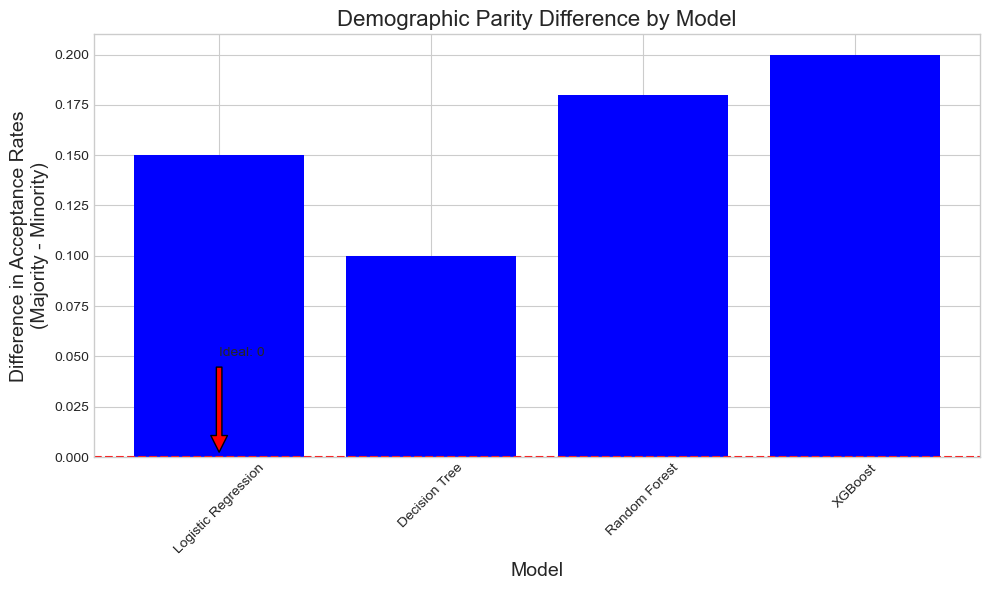

In [69]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
demographic_parity_diff = [0.15, 0.10, 0.18, 0.20]  # Difference in acceptance rates

plt.figure(figsize=(10, 6))
bars = plt.bar(models, demographic_parity_diff, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Demographic Parity Difference by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Difference in Acceptance Rates\n(Majority - Minority)', fontsize=14)
plt.xticks(rotation=45)

# Add a note about ideal value
plt.annotate('Ideal: 0', xy=(0, 0), xytext=(0, 0.05),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.tight_layout()
plt.show()

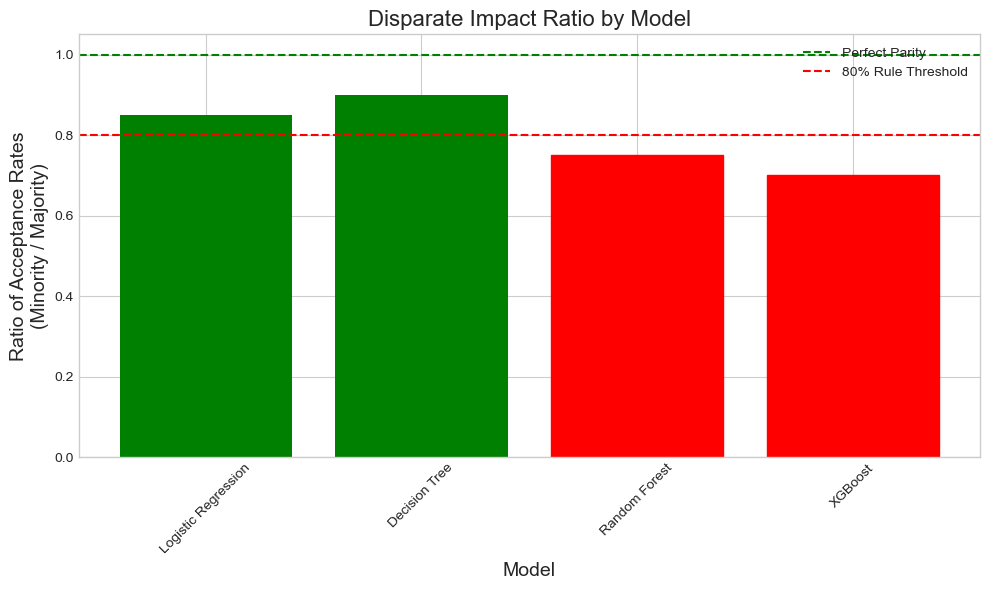

In [70]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
disparate_impact = [0.85, 0.90, 0.75, 0.70]  # Ratio of minority to majority acceptance rates

plt.figure(figsize=(10, 6))
bars = plt.bar(models, disparate_impact, color='green')
plt.axhline(y=1.0, color='g', linestyle='--', label='Perfect Parity')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Rule Threshold')
plt.title('Disparate Impact Ratio by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Ratio of Acceptance Rates\n(Minority / Majority)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()

# Highlight bars that fail the 80% rule
for i, v in enumerate(disparate_impact):
    if v < 0.8:
        bars[i].set_color('red')

plt.tight_layout()
plt.show()

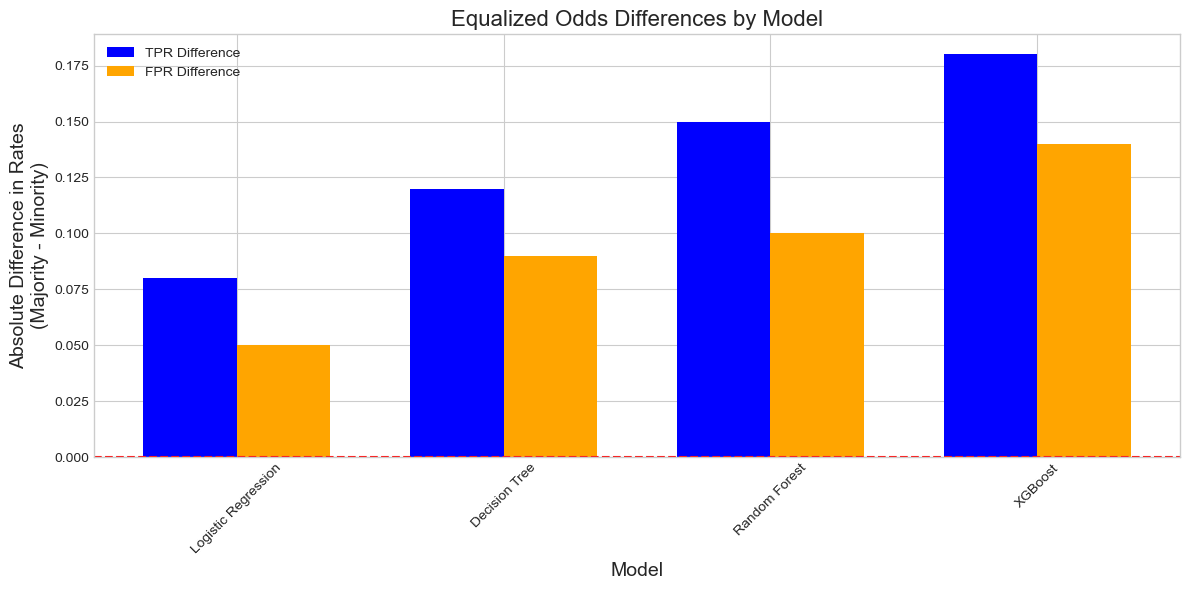

In [71]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
tpr_diff = [0.08, 0.12, 0.15, 0.18]  # Difference in true positive rates
fpr_diff = [0.05, 0.09, 0.10, 0.14]  # Difference in false positive rates

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, tpr_diff, width, label='TPR Difference', color='blue')
plt.bar(x + width/2, fpr_diff, width, label='FPR Difference', color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Equalized Odds Differences by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Absolute Difference in Rates\n(Majority - Minority)', fontsize=14)
plt.xticks(x, models, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
np.random.seed(42)
n = 200
data_3d = pd.DataFrame({
    'SAT_AVG': np.random.normal(1200, 150, n),
    'PCTPELL': np.random.uniform(0.1, 0.5, n),
    'C150_4': np.random.uniform(0.3, 0.9, n),
    'MINORITY_STATUS': np.random.randint(0, 2, n)
})

# Generate admission probabilities based on features
data_3d['Admission_Prob'] = 1 / (1 + np.exp(-(
    (data_3d['SAT_AVG'] - 1100) / 200 + 
    (0.3 - data_3d['PCTPELL']) / 0.2 + 
    (data_3d['C150_4'] - 0.5) / 0.2 - 
    0.5 * data_3d['MINORITY_STATUS']  # Bias term
)))

data_3d['Admission_Decision'] = (data_3d['Admission_Prob'] > 0.5).astype(int)

# Create 3D scatter plot
fig = px.scatter_3d(
    data_3d, 
    x='SAT_AVG', 
    y='PCTPELL', 
    z='C150_4',
    color='MINORITY_STATUS',
    symbol='Admission_Decision',
    size='Admission_Prob',
    color_discrete_map={0: 'blue', 1: 'green'},
    symbol_map={0: 'circle', 1: 'square'},
    opacity=0.7,
    title='3D Visualization of Admission Factors'
)

fig.update_layout(
    scene=dict(
        xaxis_title='SAT Score',
        yaxis_title='Pell Grant %',
        zaxis_title='Graduation Rate'
    ),
    width=1000,
    height=800
)

fig.show()

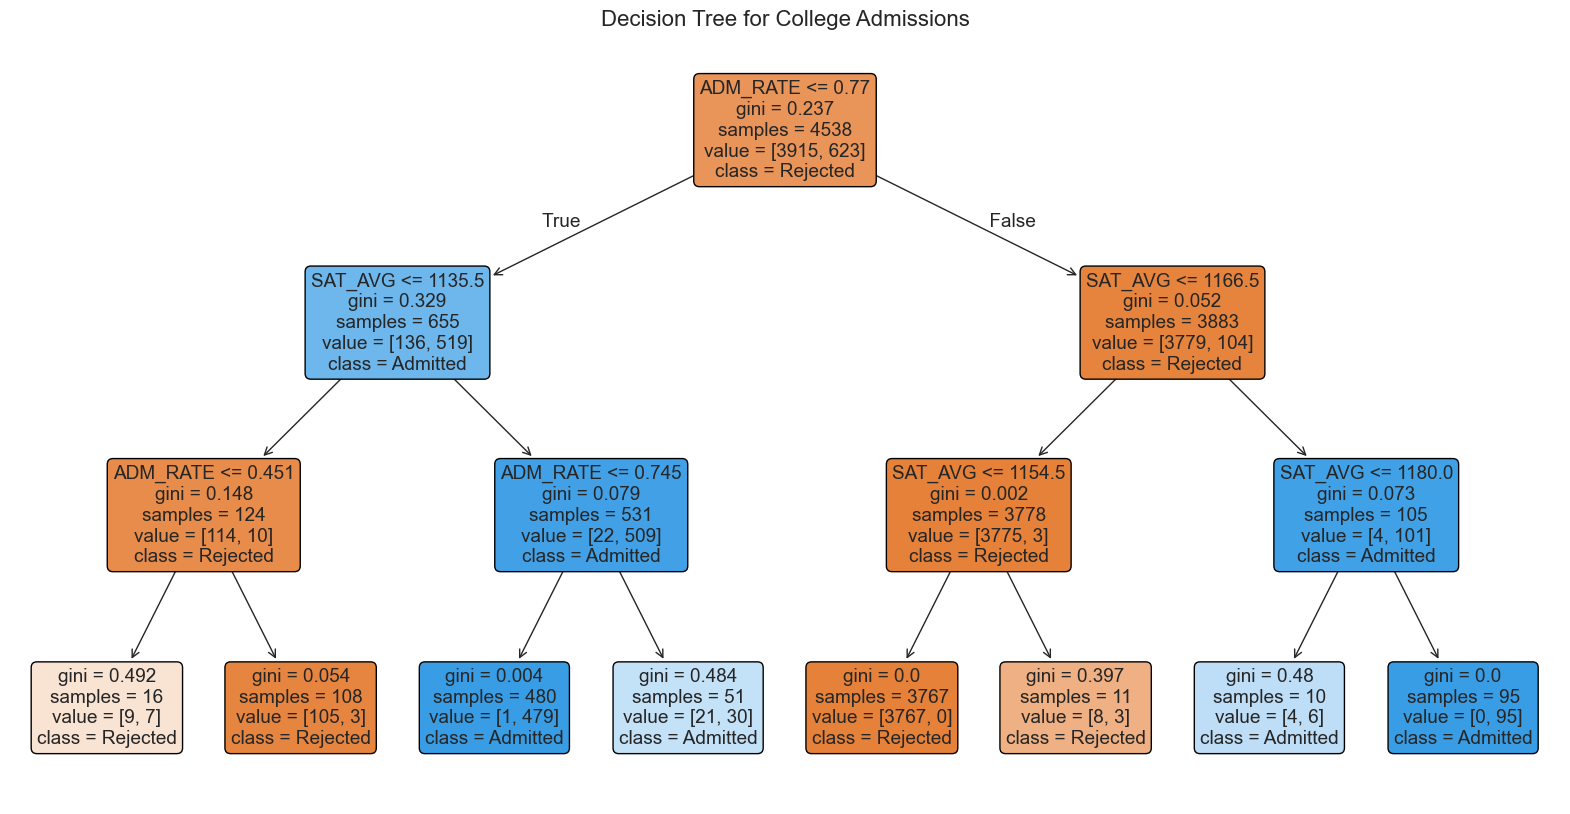

In [73]:
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Rejected', 'Admitted'], filled=True, rounded=True)
plt.title('Decision Tree for College Admissions', fontsize=16)
plt.show()

<Figure size 1400x1000 with 0 Axes>

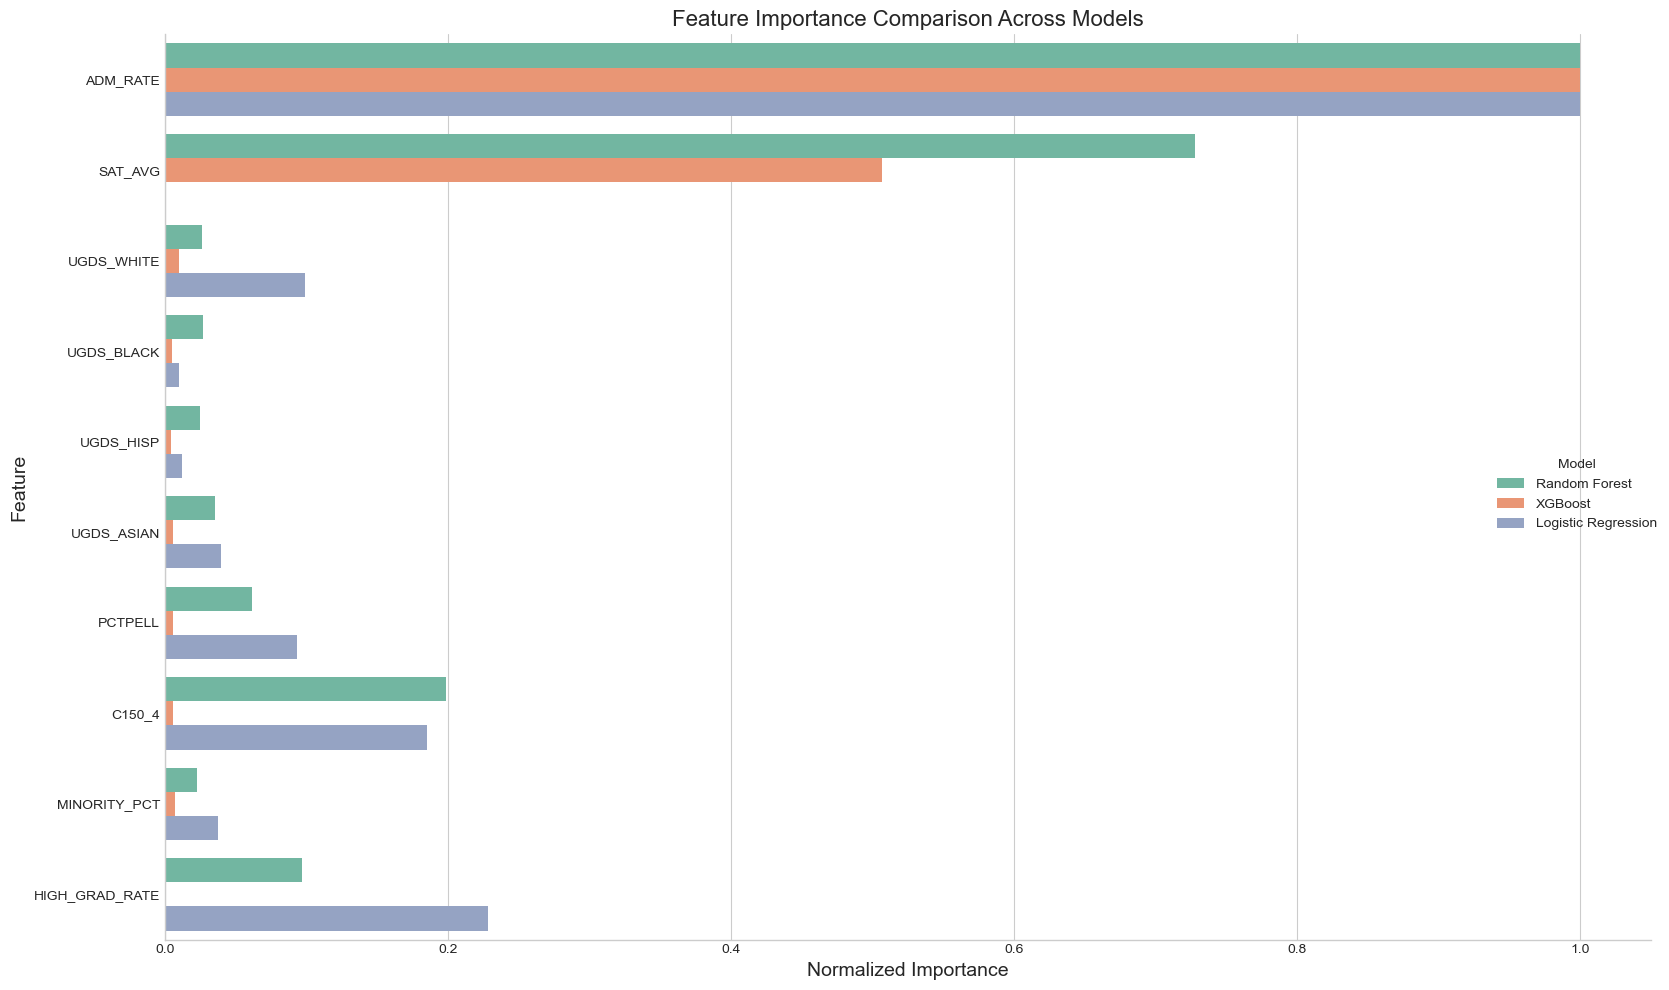

In [74]:
# Get feature importance from multiple models
feature_names = X_train.columns

# Random Forest importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_model.feature_importances_
})

# XGBoost importance
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': xgb_model.feature_importances_
})

# Logistic Regression coefficients (absolute values for importance)
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_importance = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression': np.abs(lr_model.coef_[0])
})

# Combine all importances
all_importances = rf_importance.merge(xgb_importance, on='Feature').merge(lr_importance, on='Feature')

# Melt the dataframe for easier plotting
melted_importances = pd.melt(all_importances, id_vars=['Feature'], 
                             var_name='Model', value_name='Importance')

# Normalize importances per model for fair comparison
for model in melted_importances['Model'].unique():
    max_value = melted_importances[melted_importances['Model'] == model]['Importance'].max()
    melted_importances.loc[melted_importances['Model'] == model, 'Importance'] /= max_value

# Plot
plt.figure(figsize=(14, 10))
g = sns.catplot(x='Importance', y='Feature', hue='Model', data=melted_importances, kind='bar', height=10, aspect=1.5)
plt.title('Feature Importance Comparison Across Models', fontsize=16)
plt.xlabel('Normalized Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

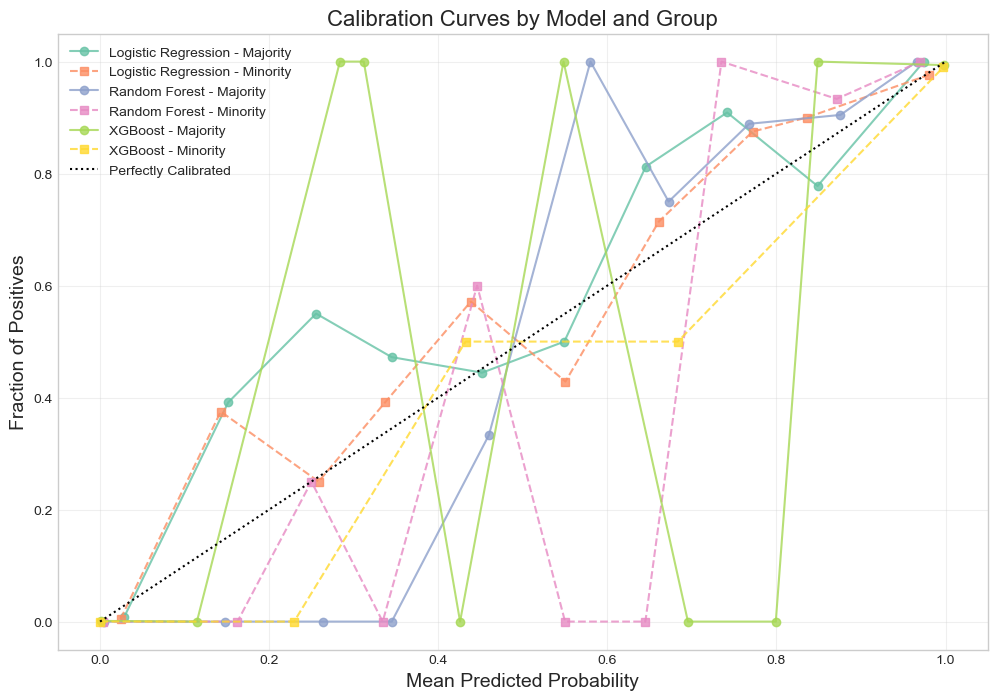

In [75]:
plt.figure(figsize=(12, 8))

for model_name, model in [('Logistic Regression', lr_model), ('Random Forest', rf_model), ('XGBoost', xgb_model)]:
    # Get predicted probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute calibration curve for majority group
    prob_true_maj, prob_pred_maj = calibration_curve(
        y_test[protected_test == 0], 
        y_prob[protected_test == 0], 
        n_bins=10
    )
    
    # Compute calibration curve for minority group
    prob_true_min, prob_pred_min = calibration_curve(
        y_test[protected_test == 1], 
        y_prob[protected_test == 1], 
        n_bins=10
    )
    
    # Plot calibration curves
    plt.plot(prob_pred_maj, prob_true_maj, marker='o', linestyle='-', 
             label=f'{model_name} - Majority', alpha=0.8)
    plt.plot(prob_pred_min, prob_true_min, marker='s', linestyle='--', 
             label=f'{model_name} - Minority', alpha=0.8)


plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.title('Calibration Curves by Model and Group', fontsize=16)
plt.xlabel('Mean Predicted Probability', fontsize=14)
plt.ylabel('Fraction of Positives', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()